In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import mediapipe as mp
from pathlib import Path
from time import time
rng = np.random.default_rng()

<h3>Functions</h3>

get_hand_from_file(filepath)
get_hand_from_image(image)
    return: pair (exit_code, img_out) 
    exit_code is 1 on success and 0 on failure. 
    img_out is a cropping of the input image around the detected hand on success, the input image itself on failure.
    
rescale_square(image, size)
    return: the given image, up- or down-sampled to a square of side length <i>size</i>.
    assumes <i>image</i> has the shape of a square. if not, use square_and_rescale().
    if <i>image</i> already has the specified size, it's returned unaltered
    
square_and_rescale(image, size)
    return: a square image of side length <i>size</i>, containing <i>image</i> up- or down-sampled so that its longest side has the specified length, padded with noise or zeros if <i>image</i> is not already a square.
    the padding is randomly added above or below, or left or right, of the scaled image, as appropriate.
    will try to convert the given image's datatype to uint8, or if <i>datatype='float32'</i> is specified to float32.
    noise options are <i>fill_type=</i> 'uniform', 'gauss', or 'int' (or anything else for zeros). an exception will be raised if the random number type (float32 for 'uniform' and 'gauss', uint8 for 'int', anything for zeros) does not agree with the specified datatype for the image.

In [186]:
def clamp(x, y, sizes):
    x = max(0, min(x, sizes[1]))
    y = max(0, min(y, sizes[0]))
    return x,y

# a 'rectangle corners' is a pair (min_corner, max_corner), where min_corner = (x_min, y_min) is the vertex with
# smallest co-ordinates and max_corner = (x_max, y_max) is the vertex with the largest co-ordinates
def get_bounding_box_corners(landmark_values, size, pad_fraction=0.2, pad_constant=5):
    coord_list_x = []
    coord_list_y = []
    y_size, x_size = size
    for landmark in landmark_values:
        coord_list_x.append(int(landmark.x * x_size))
        coord_list_y.append(int(landmark.y * y_size))
    x_min, x_max, y_min, y_max = min(coord_list_x), max(coord_list_x), min(coord_list_y), max(coord_list_y)
    x_pad, y_pad = pad_constant+int((x_max - x_min)*pad_fraction), pad_constant+int((y_max-y_min)*pad_fraction)
    min_corner = clamp(x_min-x_pad, y_min-y_pad, size)
    max_corner = clamp(x_max+x_pad, y_max+y_pad, size)
    return (min_corner, max_corner)

def get_rectangle(corners, image):
    return image[corners[0][1]:corners[1][1], corners[0][0]:corners[1][0]]

def get_bounding_box(landmark_values, image, **kwargs):
    return get_rectangle(get_bounding_box_corners(landmark_values, image.shape[0:2], **kwargs), image)

def get_rectangle_join_corners(rectangle_list):
    min_corner = (np.inf, np.inf)
    max_corner = (0,0)
    for rectangle in rectangle_list:
        min_corner = (min(min_corner[0], rectangle[0][0]), min(min_corner[1], rectangle[0][1]))
        max_corner = (max(max_corner[0], rectangle[1][0]), max(max_corner[1], rectangle[1][1]))
    return (min_corner, max_corner)

def get_rectangle_meet_corners(rectangle_list):
    min_corner = (0,0)
    max_corner = (np.inf, np.inf)
    for rectangle in rectangle_list:
        min_corner = (max(min_corner[0], rectangle[0][0]), max(min_corner[1], rectangle[0][1]))
        max_corner = (min(max_corner[0], rectangle[1][0]), min(max_corner[1], rectangle[1][1]))
    return (min_corner, max_corner)

def get_rectangle_join(rectangle_list, image):
    corners = get_rectangle_join_corners(rectangle_list)
    return get_rectangle(corners, image)

def get_prism_join(rectangle_list, image_array):
    corners = get_rectangle_join_corners(rectangle_list)
    return image_array[:, corners[0][1]:corners[1][1], corners[0][0]:corners[1][0]]

In [3]:
# functions to normalise image shape and size

def rescale_square(image, size, 
                   upscale = cv.INTER_CUBIC,    # or cv.INTER_LINEAR, or others
                   downscale = cv.INTER_AREA,   # or cv.INTER_NEAREST, or others
                   blur = 'bilateral',          # or 'gauss' or 'none'
                   ksize = (5,5), sigmaX = 0,                  # defaults for Gaussian blur
                   d = 9, sigmaColor = 75, sigmaSpace = 75,    # detaults for bilateral blur
                   **kwargs):
    assert image.shape[0] == image.shape[1]    
    if image.shape[0] > size:
        if image.shape[2] not in [1,3]:
            return tf.image.resize(image, (size, size), method='lanczos5').numpy()
        return cv.resize(image, (size,size), interpolation=downscale)
    elif image.shape[0] < size:
        if image.shape[2] not in [1,3]:
            ret = tf.image.resize(image, (size, size), method='lanczos5').numpy()
        else:
            ret = cv.resize(image, (size,size), interpolation = upscale)
        if blur.lower() == 'gauss':            
            return cv.GaussianBlur(ret,
                                   kwargs.pop('ksize', ksize),
                                   kwargs.pop('sigmaX', sigmaX),
                                   **kwargs)
        elif blur.lower() == 'bilateral':
            return cv.bilateralFilter(ret,
                                      kwargs.pop('d', d),
                                      kwargs.pop('sigmaColor',sigmaColor),
                                      kwargs.pop('sigmaSpace',sigmaSpace),
                                      **kwargs)
        return ret
    assert image.shape[0] == size and image.shape[1] == size
    return image

def square_and_rescale(image, target_size, fill_type = 'int', fill_fraction = None, **kwargs):
    # the OpenCV functions require either float32 or uint8
    imtype = image.dtype
            
    if len(image.shape) < 3:
        image = np.expand_dims(image, 2)
    y_size, x_size, channels = image.shape
    if y_size * x_size == 1:
        return np.zeros((target_size, target_size, channels), dtype=imtype)
    fill_size = 0
    if y_size > x_size:          
        fill_size = (y_size, y_size-x_size, channels)
    elif x_size > y_size:
        fill_size = (x_size-y_size, x_size, channels)
    if x_size != y_size:
        if fill_type.lower() == 'uniform' and imtype.kind == 'f':
            fill = rng.random(size=fill_size, dtype=imtype)
        elif fill_type.lower() == 'gauss' and imtype.kind == 'f':
            fill = np.positive(rng.standard_normal(size=fill_size, dtype=imtype))
        elif fill_type.lower() == 'int' and imtype.kind == 'u':
            fill = rng.integers(0, 256, size=fill_size, endpoint=False, dtype=imtype)
        else:
            fill = np.zeros(fill_size, dtype=imtype)
        if fill_fraction is None:
            fill_fraction = rng.random()
        if y_size > x_size:
            left_fill = np.int32(np.floor(fill_fraction * np.float32(fill_size[1])))
            image = np.hstack([fill[:, 0:left_fill], image, fill[:, left_fill:]])
        elif x_size > y_size:       
            top_fill = np.int32(np.floor(fill_fraction * np.float32(fill_size[0])))
            image = np.vstack([fill[0:top_fill, :], image, fill[top_fill:, :]])
    # curiously some of the cv resize/blur functions can escape their proper ranges under some circumstances, so we clamp
    max_val = {'float32':1, 'float16':1, 'uint8':255}[str(image.dtype)]
    return np.clip(rescale_square(image, target_size, **kwargs), 0, max_val)
    
def flow_to_hsv(flow):
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv=np.zeros((flow.shape[0], flow.shape[1],3), dtype=np.float32)
    hsv[..., 0] = ang/(2*np.pi)
    hsv[..., 2] = cv.normalize(mag, None, 0, 1, cv.NORM_MINMAX)
    return (hsv)

def flow_to_rgb(flow):
    hsv, a, b = flow_to_hsv(flow)
    return cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

In [4]:
#def square_and_rescale_serial_sequence(seq, seq_shape, target_size = 128, **kwargs):
#    frame_count, seq_height, seq_width, channels = seq_shape
#    seq_area = seq_height * seq_width
#    target_area = target_size * target_size
#    fill_fraction = rng.random() # determines the fraction of fill on each side of the frames for the sequence
#    out = np.zeros((target_area*frame_count, channels), dtype=seq.dtype)
#    for k in range(frame_count):
#        out[k*target_area:(k+1)*target_area] = square_and_rescale(seq[k*seq_area:(k+1)*seq_area].reshape(seq_height,
#                                                                                                         seq_width,
#                                                                                                         channels),
#                                                            target_size = target_size,
#                                                            fill_fraction = fill_fraction, **kwargs).reshape(-1,channels)
#    return out

def square_and_rescale_serial_sequence(seq, seq_shape, target_size = 128, **kwargs):
    return square_and_rescale_sequence(seq.reshape(seq_shape), target_size=target_size, **kwargs).reshape(-1, seq_shape[-1])

def square_and_rescale_sequence(seq, target_size = 128, **kwargs):
    frame_count, seq_height, seq_width, channels = seq.shape
    seq_area = seq_height * seq_width
    target_area = target_size * target_size
    fill_fraction = rng.random()
    out = np.zeros((frame_count, target_size, target_size, channels), dtype=seq.dtype)
    for k in range(frame_count):
        out[k] = square_and_rescale(seq[k], target_size=target_size, fill_fraction=fill_fraction, **kwargs)
    return out

def square_and_rescale_files(in_prefix, in_number, out_prefix, frame_counts, hand = 0, target_size = 128, **kwargs):
    in_suffix = ['a','b'][hand] + "_" + str(in_number) + ".npy"
    in_rgb = np.load(in_prefix + "_img_" + in_suffix)
    corners = np.load(in_prefix + "_corners_" + in_suffix[2:])
    seq_count = corners.shape[1]
    if seq_count != len(frame_counts):
        print('Warning: ', in_prefix, in_number, seq_count, len(frame_counts))
    #assert seq_count == len(frame_counts)
    in_heights = [crnrs[1][1] - crnrs[0][1] for crnrs in corners[hand]]
    in_widths = [crnrs[1][0] - crnrs[0][0] for crnrs in corners[hand]]
    in_volumes = np.array([0] + [in_heights[j]*in_widths[j]*frame_counts[j] for j in range(seq_count)], dtype=np.int32)
    in_offsets = in_volumes.cumsum()
    
    target_area = target_size * target_size
    out_volumes = np.array([0] + [target_area * frame_counts[j] for j in range(seq_count)], dtype=np.int32)
    out_offsets = out_volumes.cumsum()
    
    out_rgb = np.zeros((out_offsets[-1], 3), dtype=np.uint8)    
    for j in range(seq_count):
        out_rgb[out_offsets[j]:out_offsets[j+1]] = square_and_rescale_serial_sequence(in_rgb[in_offsets[j]:in_offsets[j+1]],
                                                                              (frame_counts[j], in_heights[j],
                                                                               in_widths[j], 3), target_size=target_size,
                                                                              fill_type='int')
    out_suffix = ['a','b'][hand] + "_" + str(in_number) + "_" + str(target_size) + ".npy"
    np.save(out_prefix + "_img_" + out_suffix, out_rgb)
    del in_rgb
    del out_rgb
    
    in_flow = np.load(in_prefix + "_flow_" + in_suffix)
    in_volumes = np.array([0] + [in_heights[j]*in_widths[j]*(frame_counts[j]-1) for j in range(seq_count)], dtype=np.int32)
    in_offsets = in_volumes.cumsum()    
    
    #out_volumes = np.array([0] + [target_area * (frame_counts[j]-1) for j in range(seq_count)], dtype=np.int32)
    #out_offsets = out_volumes.cumsum()
    # pad flow with initial zero frame to get the same sizes
    out_flow = np.zeros((out_offsets[-1], 2), dtype=np.float16)
    for j in range(seq_count):
        out_flow[out_offsets[j]+target_area:out_offsets[j+1]] = square_and_rescale_serial_sequence(in_flow[in_offsets[j]:in_offsets[j+1]],
                                                                               (frame_counts[j]-1, in_heights[j],
                                                                               in_widths[j], 2), target_size=target_size,
                                                                               fill_type='zeros', blur='gauss')
    np.save(out_prefix + "_flow_" + out_suffix, out_flow)
    del in_flow
    del out_flow

In [5]:
# functions to normalise hand geometry

# put the hand landmark data in non-google-mystery-storage-object
def copy_landmarks_to_array(landmarks, array):
    assert array.shape == (21,3)
    for j in range(0,21):
        array[j][0] = landmarks._values[j].x
        array[j][1] = landmarks._values[j].y
        array[j][2] = landmarks._values[j].z
        
def get_handedness(hands_results):
    return hands_results.multi_handedness[0].classification._values[0].label
        
# transforms left hands in image co-ordinates into mirrored right hand position
# but mediapipe's chirality detection is less reliable and we should avoid using it
def transform_handedness(array):
    array[:,0] = -array[:,0]+1
    return array

def plot_hands(hand1, hand2=None, figsize = (10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    ax.scatter(hand1[:,0], hand1[:,1], hand1[:,2], marker='o')
    try:
        ax.scatter(hand2[:,0], hand2[:,1], hand2[:,2], marker='^')
    except:
        pass
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

# normalised hands have wrist at the origin, the index knuckle at (1,0,0), and the middle knuckle in the first quadrant
# of the plane z = 0 (i.e. its position is (x,y,0) with x,y positive).
def normalise_hand_position(arrayIn):
    arrayOut = arrayIn - np.array([[arrayIn[0,0], arrayIn[0,1], arrayIn[0,2]]]*21)
    if list(arrayOut[5,:]) == [0,0,0] or list(arrayOut[9,:]) == [0,0,0]:
        return arrayIn
    u1 = arrayOut[5,:] / np.linalg.norm(arrayOut[5,:])
    u3 = np.cross(u1, arrayOut[9,:])
    if u3[2] < 0:
        arrayOut[:,0] *= -1
        u3 = np.cross(u1, arrayOut[9,:])
    u3 = u3 / np.linalg.norm(u3)
    u2 = np.cross(u3, u1)
    transf = np.linalg.inv([u1, u2, u3])
    return arrayOut.dot(transf)
    
# moves a hand so its landmarks' centroid is at the origin. in tests kNN worked much worse this way.
def center_hand(array):
    temp = np.ones(array.shape[0])
    center = array.mean(axis=0)
    array[:,0] -= center[0] * temp
    array[:,1] -= center[1] * temp
    array[:,2] -= center[2] * temp

 Landmark atlas: see https://google.github.io/mediapipe/solutions/hands
 
 The landmarks start at the wrist and move to the end of each finger in turn:
 
 wrist: 0
 
 thumb: 1, 2, 3, 4
 
 index: 5, 6, 7, 8
 
 middle: 9, 10, 11, 12
 
 ring: 13, 14, 15, 16
 
 small: 17, 18, 19, 20
 
 So for example the palm is represented by the marks 0, 5, 9, 13, 17.

In [5]:
# need to finish cleaning this up
# scripts for getting geometry from existing image datasets/splits

def model_hand_from_dataset(img_dataset, normalise = True):
    hands_img = np.zeros((len(img_dataset),21,3))
    hands_wrl = np.zeros((len(img_dataset),21,3))
    success_list=[]    
    for j,image in enumerate(img_dataset):
        results = hands.process(image)
        if not results.multi_hand_world_landmarks:        
            results = hands.process(cv.flip(image,1))
        if results.multi_hand_world_landmarks:       
            copy_landmarks_to_array(results.multi_hand_landmarks[0].landmark, hands_img[j])
            copy_landmarks_to_array(results.multi_hand_world_landmarks[0].landmark,hands_wrl[j])
            if normalise:
                hands_obt[j] = normalise_hand_position(hands_obt[j])
            success_list.append(j)
    return hands_img, hands_wrl, success_list

In [ ]:
# geom_full has the same length as images, with a list of co-ordinates in the indices the detector found them, zeros elsewhere
# indices has the positions where geom_full is not zero
geom_img = {}
geom_wrl = {}
indices = {}
for key in splits:
    geom_img[key], geom_wrl[key], indices[key] = model_hand_from_dataset(images[key])
    
# geom has the hand co-ordinates with the zero entries removed
# geom_lbl has the corresponding labels in an array of the same size
geom = {}
geom_lbl = {}
for key in splits:
    geom[key] = geom_full[key][indices[key]]
    geom_lbl[key] = labels[key][indices[key]]
    print(key, geom_lbl[key].shape, labels[key].shape) 

In [ ]:
for key in splits:
    np.save("datasets/" + key + "_geom_full.npy", geom_full[key])
    np.save("datasets/" + key + "_geom.npy", geom[key])
    np.save("datasets/" + key + "_geom_lbl.npy", geom_lbl[key])
    np.save("datasets/bak/" + key + "_geom_indices.npy", indices)

Tests/examples for square_and_rescale()

(91, 79)


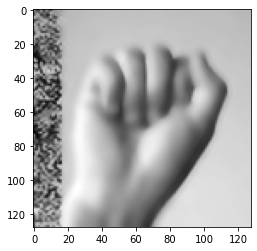

In [575]:
grey_img=cv.imread("temp/A9.jpg",flags=0)
print(grey_img.shape)
plt.imshow(square_and_rescale(grey_img,128, fill_type='int'), 'gray')
plt.show()

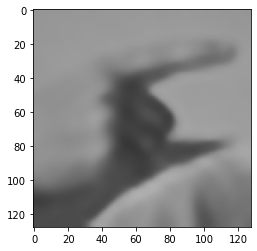

In [577]:
img = cv.imread("temp/0.png")
plt.imshow(square_and_rescale(img, 128))
plt.show()

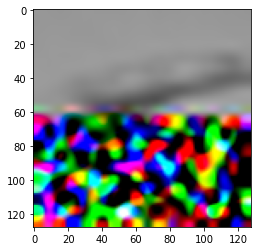

In [587]:
crop = np.float32(img[0:10,5:25])/255
newimg = square_and_rescale(crop, 128, fill_type='gauss', blur='gauss')
plt.imshow(newimg)
plt.show()

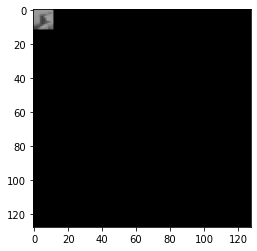

In [585]:
bigimg = np.zeros((300,300,3), dtype=np.uint8)
bigimg[0:28,0:28] = img

newimg = square_and_rescale(bigimg, 128)
plt.imshow(newimg)

In [ ]:
# a dict of all the keys and values that appear (except 'subgroup') in datasets I've tagged
# this isn't used for anything yet (maybe never will)
keywords={'dataset':['cap','dis','grass','mav1','mav2','urgarg'],'subgroup':['none'], 'colour':['greyscale','rbg','bgr'], 
          'crop':['close','none'], 'size':['small','large','128'], 'shape':['square', 'rectangle'],
         'fill':['gauss','uniform','int','zeros']}

In [155]:
# in collecting our datasets together some will use different expressions for the same sign, for example, 'a' and 'A'.
# Here we settle which expression we will use.
def standardise_sign(sign):
    try:
        return sign.lower()
    except:
        return sign

splits = ['train','val','hold']
# train is the training data, val is the model cross-validation data, hold is the final check data

In [6]:
dis_ord = rng.permutation([1,2,3,4,5])
grs_ord = rng.permutation([1,2,3,4])    
urg_ord = rng.permutation([3,4,5,6,7,9,10])
print(dis_ord, grs_ord, urg_ord)

[2 3 1 4 5] [3 4 2 1] [ 7 10  4  9  6  3  5]


In [156]:
# for each dataset, determine which elements go into which splits

# these datasets are composed of subgroups each of which must go into only one split
dis_ord = [2,3,1,4,5]
grs_ord = [3,4,2,1]
urg_ord = [7,10,4,9,6,3,5]    

dis_split = (3,4,5) # cumulative sum of (3,1,1)
grs_split = (2,3,4) #                   (2,1,1)
urg_split = (5,6,7) #                   (5,1,1)

dis_dict = {'hand'+ str(j) : 0 for j in dis_ord[0:dis_split[0]]}
dis_dict.update( {'hand'+ str(j) : 1 for j in dis_ord[dis_split[0]:dis_split[1]] } )
dis_dict.update( {'hand'+ str(j) : 2 for j in dis_ord[dis_split[1]:] } )

grs_dict = {'video'+str(j) : 0 for j in grs_ord[0:grs_split[0]]}
grs_dict.update( {'video'+ str(j) : 1 for j in grs_ord[grs_split[0]:grs_split[1]]})
grs_dict.update( {'video'+ str(j) : 2 for j in grs_ord[grs_split[1]:]})

urg_dict = {'user_'+str(j) : 0 for j in urg_ord[0:urg_split[0]]}
urg_dict.update( {'user_'+ str(j) : 1 for j in urg_ord[urg_split[0]:urg_split[1]] } )
urg_dict.update( {'user_'+ str(j) : 2 for j in urg_ord[urg_split[1]:]})

# returns name of a list split. 'bad_lbl' is the error return code, but currently that'll just raise an exception
def assignment(dataset, subgroup, index=0):
    if dataset == 'cap':
        if subgroup == 'model1':
            return 0
        elif subgroup == 'model2':
            try:
                if index % 4 != 0:
                    return 1
                else:
                    return 2
            except:
                return 'bad_lbl'
        else:
            return 'bad_lbl'
        
    if dataset == 'dis':
        return dis_dict.get(subgroup, 'bad_lbl')       
    if dataset == 'grass':
        return grs_dict.get(subgroup, 'bad_lbl')
    if dataset == 'urgarg':
        return urg_dict.get(subgroup, 'bad_lbl')
    
    # datasets without repeated models
    if dataset in ['mav1', 'mav2', 'lee']:
        try:
            if index % 5 != 0:
                return 0
            if index % 15 != 0:
                return 1
            if index % 15 == 0:
                return 2
        except:
            return 'bad_lbl' 

    # single-model datasets unsuitable to be split
    if dataset in ['bredun']:
        return 0
    return 'bad_lbl'          

In [245]:
# script for loading datasets saved as numpy arrays. the image filenames should be prefixed with img, the labels with lbl.
path = "datasets/bak/"

imagesets = []
labelsets = []
for file in Path(path).iterdir():
    if not file.is_file():
        continue
    if file.name[0:3] == 'img':
        imagesets.append(np.load(str(file), allow_pickle=True))
    elif file.name[0:3] == 'lbl':
        labelsets.append(np.load(str(file), allow_pickle=True))

In [212]:
hands_static = mp.solutions.hands.Hands(static_image_mode=True,
                                        max_num_hands=1,
                                        min_detection_confidence=0.5)

def get_hand_from_image(image, colour = 'rgb', pad_fraction = 0.2, pad_constant = 5):
    if colour.lower() == 'bgr':
        results = hands_static.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    else:
        results = hands_static.process(image)
    if not results.multi_hand_landmarks:
        return (0, image, np.zeros((21,3), dtype=np.float32), np.zeros((21,3), dtype=np.float32))

    marks = results.multi_hand_landmarks[0].landmark
    crop = get_bounding_box(marks, image, pad_fraction=pad_fraction, pad_constant=pad_constant)
    marks_img = np.zeros((21,3), dtype=np.float32)        
    copy_landmarks_to_array(marks, marks_img)
    marks_img = normalise_hand_position(marks_img)
        
    marks = results.multi_hand_world_landmarks[0].landmark
    marks_wrl = np.zeros((21,3), dtype=np.float32)
    copy_landmarks_to_array(marks, marks_wrl)
    marks_wrl = normalise_hand_position(marks_wrl)
    return ret, crop, marks_img, marks_wrl

def get_hand_from_file(filepath, **kwargs):
    image = cv.cvtColor(cv.flip(cv.imread(filepath), 1), cv.COLOR_BGR2RGB)
    return get_hand_from_image(image, **kwargs)

In [249]:
# script for standardising images from datasets and splitting them among sets train, val, hold
# at the moment this assumes each image has a single hand to get
generate_geometry = False
target_size = 128
fill_type = 'int'
blur_type = 'bilateral'

images = {'bad_lbl':[]}
geom_img ={'bad_lbl':[]}
geom_wrl = {'bad_lbl':[]}
labels = {'bad_lbl':[]}
images.update({key:[] for key in splits})
geom_img.update({key:[] for key in splits})
geom_wrl.update({key:[] for key in splits})
labels.update({key:[] for key in splits})

target_shape = 'square'
justnow = time()
filecount = 0
geom_fail_count = 0
max_sign_length = 0
for setindex, imgset in enumerate(imagesets):
    for imgindex, img in enumerate(imgset):
        lbl = labelsets[setindex][imgindex]
        if lbl.get('colour', 'rgb').lower() == 'bgr':
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            lbl.update({'colour':'rgb'})   
            
        if generate_geometry or lbl.get('crop', False) != 'close':
            ret, img, marks_img, marks_wrl = get_hand_from_image(img)
            if ret:
                lbl.update({'crop':'close'})
            
            img = square_and_rescale(img,
                                target_size,
                                fill_type = fill_type,
                                blur = blur_type)
            lbl.update({'shape':'square','size':str(target_size),'blur':blur_type})
        else:
            img = square_and_rescale(img, target_size, fill_type=fill_type, blur = blur_type)
        lbl.update({'shape':'square','size':str(target_size), 'fill':fill_type, 'blur':blur_type})
        assign = assignment(lbl.get('dataset', None), lbl.get('subgroup', None), imgindex)
        if assign == 'bad_lbl':
            print('Bad label generated: ', setindex, imgindex, lbl)
        else:
            assign = splits[assign]
        sign = standardise_sign(lbl['sign'])
        max_sign_length = max(len(sign), max_sign_length)
        lbl.update({'sign': sign})
        try:
            images[assign].append(img)
            if generate_geometry:
                geom_img[assign].append(marks_img)
                geom_wrl[assign].append(marks_wrl)
            labels[assign].append(lbl)
        except:
            print("Exc:", setindex, imgindex, assign)
        filecount += 1
now = time()
print('Elapsed time: ', now-justnow)
print('FPS: ', filecount/(now-justnow))

Elapsed time:  88.2386429309845
FPS:  408.5624937386803


In [251]:
sign_dtype = '<U' + str(max_sign_length)
sign_labels = {key: np.zeros((len(images[key])), dtype = sign_dtype) for key in splits}

for key in splits:
    for j, lbl in enumerate(labels[key]):
        sign_labels[key][j] = labels[key][j]['sign']
    print(len(sign_labels[key]))

26559
5793
3699


In [252]:
label_set = np.unique(sign_labels[splits[0]])
label_count = len(label_set)
for key in splits:
    assert label_count == len(np.unique(sign_labels[key]))

In [253]:
# replaces sign string labels with id numbers
encoder = {label_set[ind]:ind for ind in range(label_count)}
print(encoder)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'bye': 12, 'c': 13, 'd': 14, 'del': 15, 'e': 16, 'f': 17, 'g': 18, 'good': 19, 'good morning': 20, 'h': 21, 'hello': 22, 'i': 23, 'j': 24, 'k': 25, 'l': 26, 'little bit': 27, 'm': 28, 'n': 29, 'no': 30, 'null': 31, 'o': 32, 'p': 33, 'pardon': 34, 'please': 35, 'project': 36, 'q': 37, 'r': 38, 's': 39, 'space': 40, 't': 41, 'u': 42, 'v': 43, 'w': 44, 'whats up': 45, 'x': 46, 'y': 47, 'yes': 48, 'z': 49}


In [165]:
# replaces id numbers with sign string labels, for when you want it
decoder = {encoder[key]:key for key in encoder.keys()}
print(decoder)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'bye', 13: 'c', 14: 'd', 15: 'del', 16: 'e', 17: 'f', 18: 'g', 19: 'good', 20: 'good morning', 21: 'h', 22: 'hello', 23: 'i', 24: 'j', 25: 'k', 26: 'l', 27: 'little bit', 28: 'm', 29: 'n', 30: 'no', 31: 'null', 32: 'o', 33: 'p', 34: 'pardon', 35: 'please', 36: 'project', 37: 'q', 38: 'r', 39: 's', 40: 'space', 41: 't', 42: 'u', 43: 'v', 44: 'w', 45: 'whats up', 46: 'x', 47: 'y', 48: 'yes', 49: 'z'}


In [254]:
for key in splits:
    for j, lbl in enumerate(labels[key]):
        sign_labels[key][j] = encoder[sign_labels[key][j]]
    sign_labels[key] = np.uint8(sign_labels[key])

In [255]:
path = "datasets/"
for key in splits:
    np.save(path + key + "_img_128.npy", images[key])
    np.save(path + key + "_lbl.npy", sign_labels[key])

In [193]:
path = "datasets/"
for key in splits:    
    np.save(path + key + "_geom_img.npy", geom_img[key])
    np.save(path + key + "_geom_wrl.npy", geom_wrl[key])

<h3>Input channel expansion</h3>

Shorten-Khoshgoftaar venture that "a disadvantage of this technique [augmentation by kernel filters] is that it is very similar to the internal mechanisms of CNNs. CNNs ... learn the optimal way to represent images layer-by-layer.... Kernel filters can be better implemented as a layer of the network rather than as an addition to the dataset through data augmentation." On the other hand, Kukacka-Golkov-Cremers opine "known meaningful data transformations should not be outsourced to the learning. Redundantly providing the same information in several representations is okay."

In this case I tried adding some Scharr derivatives. It did not help.

In [6]:
images = {}
for key in splits:
    images[key] = np.load("datasets/" + key + "_img_64.npy")

In [7]:
# augmentation w/ Scharr derivatives
for key in splits:
    Scharr_x = np.zeros_like(imgs[key], dtype='uint8')
    Scharr_y = np.zeros_like(imgs[key], dtype='uint8')
    for j in range(0, len(imgs[key])):
        Scharr_x[j] = cv.Scharr(imgs[key][j], -1, 1, 0)
        Scharr_y[j] = cv.Scharr(imgs[key][j], -1, 0, 1)
    imgs[key] = np.concatenate([imgs[key], Scharr_x, Scharr_y], axis=3)

In [9]:
path = "datasets/"
for key in splits:
    np.save(path + key + "_img_64_Scharr.npy", imgs[key])

<h2>Data Augmentation</h2>

<h3>Supplementing data with synthetics</h3>

Shorten-Khoshgoftaar write positively of (among methods that themselves do not involve ML in their construction) rotations, random erasure, and certain image-mixing methods. (Cropping they find is the most important such augmentation. Since our data is already cropped from bounding boxes, this amounts to the same as translation, which is regarded as a less-effective method when training CNNs.) The image-mixing methods include 'patchwork' transforms that move segments of an image, or replace them with segments from another image, as well as superposition of images (averaging their pixel values), including superposition of images different labels! The apparent senselessness of such manipulations lead them to remark on "the sometimes unreasonable effectiveness of big data with deep learning models."

Among ML-based methods, there is one off-the-shelf method which they recommend, style transfer. They laud it as "one of the flashiest demonstrations of Deep Learning capabilities," and say its application to data augmentation is "a much more powerful augmentation technique than traditional color space augmentations."

There is a subfield of designing data augmentation strategies to make an 'optimal curriculum.' One ML strategy to tackle this problem is called AutoAugment. Albumentations apparently has an implementation of a subsequent refinement of this method, "Fast AutoAugment." See https://albumentations.ai/docs/autoalbument/ 

In [256]:
import albumentations as al

In [257]:
# apply two transforms, chosen randomly from a number of sublists
synth = al.SomeOf([al.OneOf([al.Rotate(limit=10),
                              al.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=5)]),
                    al.OneOf([al.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
                              al.RandomToneCurve(),
                              al.Equalize()]),
                    al.OneOf([al.Sharpen(alpha=(0.3, 0.6)),
                                #al.CLAHE(),
                                al.Emboss(alpha=(0.3,0.6), strength=(0.3,0.6))]),
                    al.FancyPCA(alpha=0.5),
                    al.OneOf([al.CoarseDropout(max_holes=8, max_height=8, max_width=8, 
                                                min_holes=4, min_height=4, min_width=4, 
                                                fill_value=0),
                              al.Spatter(mode='rain', intensity=.6, cutout_threshold=0.68),
                              al.Superpixels(p_replace=0.15)]),
                    al.OneOf([al.GridDistortion(num_steps=3, distort_limit=0.1),
                             al.OpticalDistortion(distort_limit=0.1, shift_limit=0.1)])],
                  n=2, replace=False)

In [262]:
image_size = 128

images={}
sign_labels={}
geom_img={}
geom_wrl={}
images['train'] = np.load("datasets/train_img_"+str(image_size)+".npy")
geom_img['train'] = np.load("datasets/train_geom_img.npy")
geom_wrl['train'] = np.load("datasets/train_geom_wrl.npy")
sign_labels['train']=np.load("datasets/train_lbl.npy")

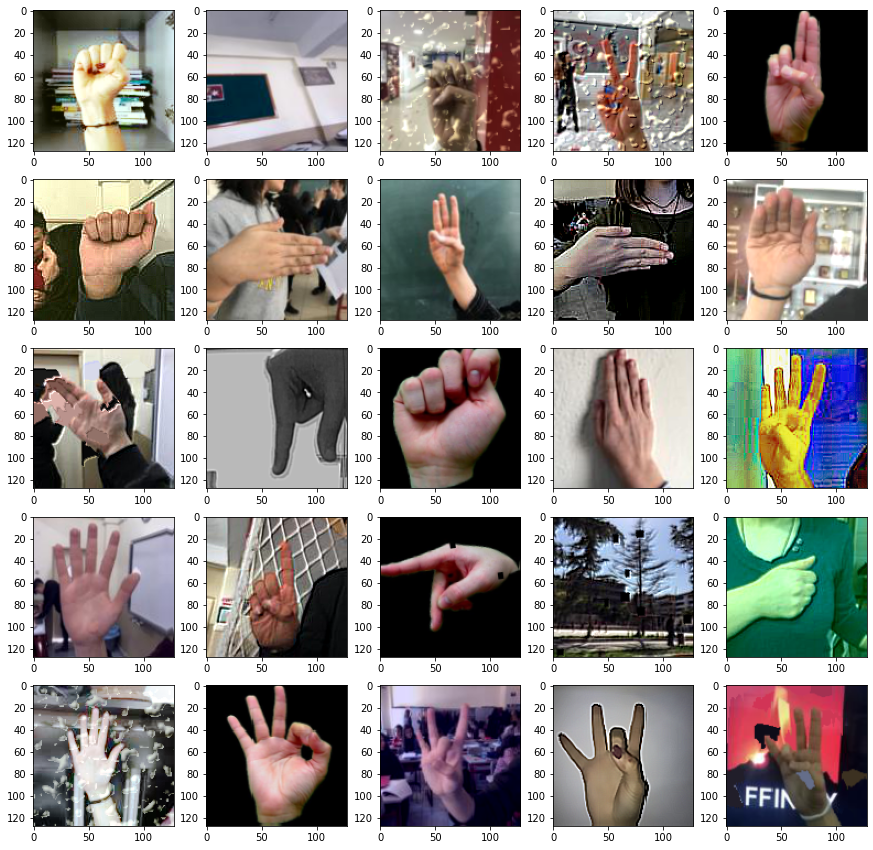

In [263]:
length = len(images['train'])
plt.figure(figsize=(15,15))
for j in range(1,26):
    img = synth(image=images['train'][rng.integers(0,length)])['image']
    plt.subplot(5,5,j), plt.imshow(img)

In [264]:
#images_length = images['train'].shape[0] 
images_length = len(images['train'])
synth_length = images_length

images_synth = np.zeros((synth_length, image_size, image_size, 3), dtype='uint8')
labels_synth = np.zeros((synth_length), dtype='uint8')
geom_img_synth = np.zeros((synth_length, 21,3), dtype='float32')
geom_wrl_synth = np.zeros((synth_length, 21,3), dtype='float32')
justnow = time()
for j in range(0, synth_length):
    random_draw = rng.integers(0,images_length)
    images_synth[j] = synth(image=images['train'][random_draw])['image']
    labels_synth[j] = sign_labels['train'][random_draw]
    geom_img_synth[j] = geom_img['train'][random_draw]
    geom_wrl_synth[j] = geom_wrl['train'][random_draw]
now = time()
print("Elapsed time", now-justnow, ", FPS", synth_length/(now-justnow))

Elapsed time 156.96271872520447 , FPS 169.2057847602461


In [265]:
suffix = str(image_size) + "_synth.npy"
np.save("datasets/train_img_"+suffix, images_synth)
np.save("datasets/train_lbl_"+suffix, labels_synth)
np.save("datasets/train_geom_img_"+suffix, geom_img_synth)
np.save("datasets/train_geom_wrl_"+suffix, geom_wrl_synth)

There's also a notion of test-time data augmentation: when the trained model is being evaluated, have it randomly generate some synthetic data of the type it's been trained on and see what it predicts for those as well. (Then it can take a vote or whatever.) Perhaps this could partly substitute for lack of sensorimotor variation in the static case. 

What tf does natively/dynamically: Contrast, Brightness, Crop, Flip, Height, Rotation, Translation, Width, Zoom; GaussianNoise

Some Albumentations methods not covered by the above: FancyPCA; CoarseDropout, Spatter, Superpixels; GridDistortion, OpticalDistortion; GlassBlur; Emboss, CLAHE, Sharpen; RandomGridShuffle

<h3>Image mixing</h3>

Examples of an unexpected data augmentation technique: mixing images by averaging their pixel values. Even more surprising, they say it can work even better if you mix images with different labels! (The label of the resulting superposition is randomly chosen from those of its components.)

In [588]:
img1 = cv.cvtColor(cv.imread("temp/A9.jpg"), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread("temp/A8.jpg"), cv.COLOR_BGR2RGB)

In [589]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255

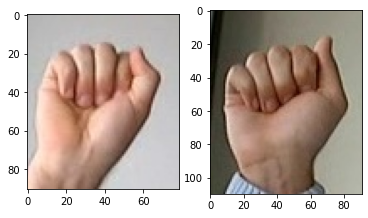

In [591]:
plt.subplot(1,2,1), plt.imshow(img1)
plt.subplot(1,2,2), plt.imshow(img2)
plt.show()

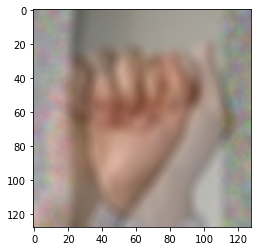

In [592]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3)
plt.show()

In [593]:
img1 = cv.imread('temp/11.png', flags=0)
img2 = cv.imread('temp/45.png', flags=0)

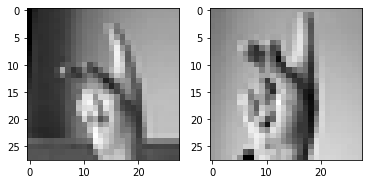

In [594]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255
plt.subplot(1,2,1), plt.imshow(img1, 'gray')
plt.subplot(1,2,2), plt.imshow(img2, 'gray')
plt.show()

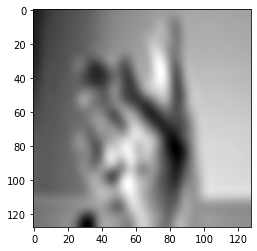

In [596]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3, 'gray')
plt.show()

<h2>ChicagoFSWild</h2>

The following scripts put the ChicagoFSWild dataset into ragged arrays/tensors suitable for use. For each frame up to 2 hands are taken and their respective bounding boxes are put into a list <i>images[key]</i> of length 2. At the same time the normalised hand landmark geometry data goes into <i>geom_img</i> and <i>geom_wrl</i>, and the TV-$L^1$ optical flow goes into <i>flow</i>. Everywhere something is not detected the lists are padded with zeros of the appropriate shape.

Each image list is schematically a ragged array with shape 

    [sequences, (frame_counts), (frame_heights), (frame_widths), channels], 

where the middle three axes are ragged in general (if the boxes are reshaped to squares only (frame_counts) is ragged). In order to store this efficiently it's saved as a flattened array. The data necessary to reconstruct the ragged array are the number_of_frames column in the ChicagoFSWild csv and the dimensions of each box. The auxiliary lists <i>corners</i> records where the cropped prism was in the original image, and the box dimensions can be computed from this. TensorFlow has a native RaggedTensor class which can do the reconstruction given this information the right way (as illustrated below).

In [7]:
hands_two = mp.solutions.hands.Hands(static_image_mode=False,
                                    max_num_hands=2,
                                    min_detection_confidence=0.4)

def get_hands_from_image(image, colour = 'rgb', pad_fraction = 0.2, pad_constant = 5):
    global hands_two
    if colour.lower() == 'bgr':
        results = hands_two.process(cv.cvtColor(image), cv.COLOR_BGR2RGB)
    else:
        results = hands_two.process(image)
    ret = 0
    if not results.multi_hand_landmarks:
        return (ret, [[(0,0),image.shape[0:2]]],[np.zeros((21,3))], [np.zeros((21,3))])
    marks_img = {} 
    marks_wrl = {}
    corners = {}
    for hand in range(len(results.multi_hand_landmarks)):
        # mp.Hands does left/right determination but it's not good enough
        #hand = results.multi_handedness[index].classification[0].label.lower()
        
        # mp.Hands generates two landmark sets, differing essentially in how they treat the depth of landmarks
        # the 'image position' estimates distance from the camera, I guess using some image proc methods
        # the 'world position' appears to estimate real-world angles, maybe using some ML method
        # MediaPipe internally calls the latter 'normalised landmarks' but the difference is not a simple transformation
        # in basic tests (like kNN), world marks performed slightly better
        marks = results.multi_hand_landmarks[hand].landmark
        corners[hand] = get_bounding_box_corners(marks._values, image.shape[0:2],
                                                 pad_fraction=pad_fraction, pad_constant=pad_constant)
        marks_img[hand] = np.zeros((21,3), dtype=np.float32)        
        copy_landmarks_to_array(marks, marks_img[hand])
        marks_img[hand] = normalise_hand_position(marks_img[hand])
        
        marks = results.multi_hand_world_landmarks[hand].landmark
        marks_wrl[hand] = np.zeros((21,3), dtype=np.float32)
        copy_landmarks_to_array(marks, marks_wrl[hand])
        marks_wrl[hand] = normalise_hand_position(marks_wrl[hand])
        ret += 1
    return (ret, corners, marks_img, marks_wrl)

def get_hands_from_file(filepath, **kwargs):
    image = cv.cvtColor(cv.flip(cv.imread(filepath), 1), cv.COLOR_BGR2RGB)
    return get_hands_from_image(image, **kwargs)

In [147]:
import pandas as pd
#data_csv = pd.read_csv("ChicagoFSWild/ChicagoFSWild.csv", index_col=0)
data_csv = pd.read_csv("h:/project/ChicagoFSWildPlus.csv")
#data_csv.sample(5)
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55231 entries, 0 to 55230
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        55231 non-null  int64  
 1   filename          55231 non-null  object 
 2   url               54595 non-null  object 
 3   start_time        55231 non-null  object 
 4   number_of_frames  55231 non-null  int64  
 5   width             55231 non-null  int64  
 6   height            55231 non-null  int64  
 7   label_proc        55231 non-null  object 
 8   label_raw         55231 non-null  object 
 9   label_notes       0 non-null      float64
 10  partition         55231 non-null  object 
 11  signer            55231 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 5.1+ MB


In [148]:
# stats about label lengths in the dataset
data_csv['label_proc'].apply(lambda x: len(x)).describe()

count    55231.000000
mean         4.986765
std          3.474673
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         47.000000
Name: label_proc, dtype: float64

In [59]:
# stats about the number of frames per label character in the dataset
fpc = (data_csv['number_of_frames']/data_csv['label_proc'].apply(lambda x: len(x)))
fpc.describe()

count    55231.000000
mean         5.592037
std          3.234739
min          1.000000
25%          3.666667
50%          5.000000
75%          6.666667
max        108.000000
dtype: float64

In [60]:
data_csv['number_of_frames'][fpc < 4]

5        23
8        11
12        6
13       15
15       12
         ..
55215     8
55217    17
55224    26
55229    11
55230     4
Name: number_of_frames, Length: 16251, dtype: int64

In [61]:
splits = np.unique(data_csv['partition'])

#base_in = "ChicagoFSWild/frames/"
#base_out = "h:/project/cfsw/cfsw_raw/"
base_in = "h:/project/cfswp_frames/"
base_out = "h:/project/cfswp_128/"

indices = {}

# cfswp
indices['train'] =[0, 50400]
indices['dev'] = [50400, 53515]
indices['test'] = [53515, 55231]

# cfsw
#indices['train'] = [0, 5455]
#indices['dev'] = [5455, 6436]
#indices['test'] = [6436, 7304]

Mysteriously, mp.Hands sometimes returns more hands than it's told: despite being told <i>max_num_hands=2</i> (and this is the default value) in a very small number of frames (around 0.1% or so) it will return 3 hands! I can't locate why this happens; running the hands image processing by itself doesn't reproduce the bug (at least, not at the first place it happens for me in the script below). As a result this script will occasionally raise exceptions, but they are handled in general to keep the list padding correct (for this bug that's irrelevant, since it does record the data for the first two hands).

In [153]:
# having 3d kernels means it's not enough to crop a hand out of each frame; there needs to be a prism the filters
# act on. one option is to remember the individual corners and pad each crop inside the prism over their join.
# simpler is just to take the prism over their join; and twice simpler if we want to compute optical flow as well

batch_size = 512
resize = False

tv = cv.optflow.DualTVL1OpticalFlow.create(0.16, 0.87, 0.005)
# for train split, sequence is skipped if too great a fraction is non-detects
skip_threshold=0.5

total_frames = 0
justnow = time()
warnings_list=[[],[]]
#drop_list=[]
#drop_list = list(np.load(base_out+"drop_list.npy"))
splits=['train']
for key in splits:
    batch_number = 42
    total_size = indices[key][1]-indices[key][0]
    #j = indices[key][0]
    j = 21624
    while batch_number*batch_size <= total_size:
        # ready lists for the coming batch
        # two lists, one for hand A and one for hand B
        images = [[],[]]
        corners = [[],[]] # holds vertices for prism crops
        corners_by_frame = [[],[]] # holds vertices for individual frame crops found
        flow=[[],[]]
        geom_img = [[],[]]
        geom_wrl = [[],[]]
        while j < indices[key][1]:
            # for mp.Hands we use static_mode off (it's faster and catches some frames that get missed in static mode)
            #  so, mp.Hands must be told that this is the start of a new frame sequence
            hands_two.reset()
            # maintain lists local to this sequence
            # seq will be skipped if exception occurs, or it's in train split and too many nondetects occur
            nondetect = 0
            excepted = False
            images_local=[[],[]]
            corners_local=[0,0]
            crnrs_list=[[],[]]
            corners_by_frame_local=[[],[]]
            flow_local=[[],[]]
            geom_img_local=[[],[]]
            geom_wrl_local=[[],[]]
            
            directory = base_in + data_csv['filename'][j] + "/"
            frame_count = data_csv['number_of_frames'][j]
            seq = np.zeros((frame_count, data_csv['height'][j], data_csv['width'][j], 3), dtype=np.uint8)
            print(j, data_csv['filename'][j], frame_count)
            
            # load the files and run the hand detector on them
            for k in range(1, frame_count+1):
                # filenames are 4 characters, the frame number padded with zeros on the left
                if k >= 100:
                    filepath = directory + "0"+str(k)+".jpg"
                elif k >= 10:
                    filepath = directory + "00"+str(k)+".jpg"
                else:
                    filepath = directory + "000"+str(k)+".jpg"
                seq[k-1] = cv.cvtColor(cv.imread(filepath), cv.COLOR_BGR2RGB)
                ret, crnrs, marks_img, marks_wrl = get_hands_from_image(seq[k-1])
                ret = min(ret, 2)
                if ret == 0:
                    warnings_list[0].append(filepath)
                    nondetect += 1
                for hand in range(ret):
                    crnrs_list[hand].append(crnrs[hand])
                    corners_by_frame_local[hand].append(crnrs[hand])
                    geom_img_local[hand].append(marks_img[hand])
                    geom_wrl_local[hand].append(marks_wrl[hand])
                for hand in range(ret, 2):
                    # pad the lists that need padding
                    corners_by_frame_local[hand].append([(0,0), seq.shape[1:3]])
                    geom_img_local[hand].append(np.zeros((21,3), dtype=np.float32))
                    geom_wrl_local[hand].append(np.zeros((21,3), dtype=np.float32))
            for hand in range(2):
                # find the prism join of the hand bounding boxes, add it to images_local, and compute the flow
                try:
                    if len(crnrs_list[hand]) > 0:
                        corners_local[hand] = get_rectangle_join_corners(crnrs_list[hand])
                        images_local[hand] = get_prism_join([corners_local[hand]], seq)
                        for k in range(frame_count-1):
                            flow_local[hand].append(tv.calc(cv.cvtColor(images_local[hand][k], cv.COLOR_RGB2GRAY), 
                                                     cv.cvtColor(images_local[hand][k+1], cv.COLOR_RGB2GRAY),
                                                     None))
                        # pad flow with a blank initial frame to get same length as image sequences
                        flow_local[hand].insert(0, np.zeros_like(flow_local[hand][0], dtype=np.float16))
                        flow_local[hand] = np.float16(flow_local[hand])
                        
                    else:
                        corners_local[hand] = [(0,0),(1,1)]
                        images_local[hand] = np.zeros((frame_count, 1, 1, 3), dtype=np.uint8)
                        flow_local[hand] = np.zeros((frame_count, 1, 1, 2), dtype=np.float16)
                except:
                    excepted = True
                    warnings_list[1].append(j)
            total_frames += frame_count
            # last condition here ensures there's at least one frame in the flow list
            if excepted or (key == 'train' and nondetect >= frame_count*skip_threshold) or frame_count < 2:
                print("Skipping " + data_csv['partition'][j] + "/" + data_csv['filename'][j] + 
                      ", lost frames = " +str(nondetect) + "/" + str(frame_count)+
                      ", exc = " + str(excepted))
                drop_list.append(j)                
            else:
                for hand in range(2):
                    if resize:
                        images[hand].append(square_and_rescale_sequence(images_local[hand]).reshape(-1,3))
                        flow[hand].append(square_and_rescale_sequence(flow_local[hand], blur='gauss').reshape(-1,2))
                    else:
                        images[hand].append(images_local[hand].reshape(-1,3))
                        flow[hand].append(flow_local[hand].reshape(-1,2))
                    corners[hand].append(corners_local[hand])
                    corners_by_frame[hand].append(corners_by_frame_local[hand])
                    geom_img[hand].append(np.concatenate(geom_img_local[hand], axis=0))
                    geom_wrl[hand].append(np.concatenate(geom_wrl_local[hand], axis=0))
            j += 1
            if len(corners[0]) % batch_size == 0:
                break
        # save batch to file
        batch_suffix = "_" + str(batch_number) + ".npy"
        # ragged arrays flattened to array of pixel channels        
        np.save(base_out+key+"_img_a"+batch_suffix, np.concatenate(images[0], axis=0))
        np.save(base_out+key+"_img_b"+batch_suffix, np.concatenate(images[1], axis=0))
        np.save(base_out+key+"_flow_a"+batch_suffix, np.concatenate(flow[0], axis=0))
        np.save(base_out+key+"_flow_b"+batch_suffix, np.concatenate(flow[1], axis=0))
        np.save(base_out+key+"_geom_img_a"+batch_suffix, np.concatenate(geom_img[0], axis=0))
        np.save(base_out+key+"_geom_img_b"+batch_suffix, np.concatenate(geom_img[1], axis=0))
        np.save(base_out+key+"_geom_wrl_a"+batch_suffix, np.concatenate(geom_wrl[0], axis=0))
        np.save(base_out+key+"_geom_wrl_b"+batch_suffix, np.concatenate(geom_wrl[1], axis=0))
        # co-ordinates of the prism saved inside its original frame sequence
        np.save(base_out+key+"_corners"+batch_suffix, corners)
        # co-ordinates of bounding boxes in individual frames, for potential future use
        np.save(base_out+key+"_corners_a"+batch_suffix, np.concatenate(corners_by_frame[0], axis=0))
        np.save(base_out+key+"_corners_b"+batch_suffix, np.concatenate(corners_by_frame[1], axis=0))
        if key == 'train':
            np.save(base_out+"drop_list.npy", np.unique(drop_list)) # backup
        print("Saved batch " + key + "/" + str(batch_number) + ".")
        batch_number += 1
            
now = time()
print("Elapsed time", now-justnow, "FPS", total_frames/(now-justnow), "lost fraction", len(warnings_list[0])/total_frames)

21624 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_0 49
21625 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_1 59
21626 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_2 21
21627 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_3 21
21628 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_4 20
21629 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_5 10
21630 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_6 9
21631 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_7 7
21632 Batch21/Malaysian_Jet_Goes_Missing_8_A2Q8Q1BE2JQR4C_8 20
21633 Batch21/Malaysian_Jet_Goes_Missing_1_A18LZUX7ES0QI9_0 43
21634 Batch21/Malaysian_Jet_Goes_Missing_1_A18LZUX7ES0QI9_1 47
21635 Batch21/Malaysian_Jet_Goes_Missing_1_A18LZUX7ES0QI9_2 7
21636 Batch21/Malaysian_Jet_Goes_Missing_1_A18LZUX7ES0QI9_3 18
21637 Batch21/Malaysian_Jet_Goes_Missing_1_A18LZUX7ES0QI9_4 17
21638 Batch21/Malaysian_Jet_Goes_Missing_1_A18LZUX7ES0QI9_5 51
21639 Batch21/Malaysian_Jet_Goes_Missing_1_A18LZUX7ES0QI9_

21754 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_1 10
21755 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_2 6
21756 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_3 20
21757 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_4 11
21758 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_5 15
21759 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_6 18
21760 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_7 45
21761 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_8 31
21762 Batch21/Man_Walks_21_Miles_2_A18LZUX7ES0QI9_9 15
21763 Batch21/Man_Walks_21_Miles_2_A2Q8Q1BE2JQR4C_0 13
21764 Batch21/Man_Walks_21_Miles_2_A2Q8Q1BE2JQR4C_1 16
21765 Batch21/Man_Walks_21_Miles_2_A2Q8Q1BE2JQR4C_2 44
21766 Batch21/Man_Walks_21_Miles_2_A2Q8Q1BE2JQR4C_3 30
21767 Batch21/Man_Walks_21_Miles_2_A2Q8Q1BE2JQR4C_4 30
21768 Batch21/Man_Walks_21_Miles_5_A1I9C94JSHA0M_0 15
21769 Batch21/Man_Walks_21_Miles_5_A1I9C94JSHA0M_1 77
21770 Batch21/Man_Walks_21_Miles_5_A1I9C94JSHA0M_3 31
21771 Batch21/Man_Walks_21_Miles_5_A1I9C94JSHA0M_4 28
21772 Batch21/M

21893 Batch13/US_Debates_Syria_Attack_2_A2Q8Q1BE2JQR4C_8 17
21894 Batch13/US_Debates_Syria_Attack_2_A2Q8Q1BE2JQR4C_9 6
21895 Batch13/US_Debates_Syria_Attack_2_A2Q8Q1BE2JQR4C_10 7
21896 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_0 53
21897 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_1 5
21898 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_2 9
21899 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_3 12
21900 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_4 32
21901 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_5 22
21902 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_6 36
21903 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_7 11
21904 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_8 19
21905 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_9 11
21906 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_10 10
21907 Batch13/US_Debates_Syria_Attack_2_A39XPCDK2O844L_11 17
21908 Batch13/US_Debates_Syria_Attack_10_A2WGOCFKSFGADL_0 34
21909 Batch13/US_Debates_Syria_Attack_10

22031 Batch13/US_Debates_Syria_Attack_13_A2WGOCFKSFGADL_9 84
22032 Batch13/US_Debates_Syria_Attack_13_A2WGOCFKSFGADL_10 44
22033 Batch13/US_Debates_Syria_Attack_13_A2WGOCFKSFGADL_11 26
22034 Batch13/US_Debates_Syria_Attack_13_A2WGOCFKSFGADL_12 80
22035 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_0 9
22036 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_1 6
22037 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_2 26
22038 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_3 67
22039 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_4 132
22040 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_5 53
22041 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_6 26
22042 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_7 21
22043 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_8 21
22044 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_9 8
22045 Batch13/US_Debates_Syria_Attack_6_A2Q8Q1BE2JQR4C_10 8
22046 Batch13/US_Debates_Syria_Attack_6_A2WGOCFKSFGADL_0 19
22047 Batch13/US_Debates_Syria_Atta

22168 Batch13/Updates_on_Texas_Ebola_5_A3H188O2IZ80AM_3 10
22169 Batch13/Updates_on_Texas_Ebola_5_A3H188O2IZ80AM_4 69
22170 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_0 13
22171 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_1 8
22172 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_2 75
22173 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_3 52
22174 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_4 15
22175 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_5 16
22176 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_6 7
22177 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_7 3
22178 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_8 9
22179 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_9 11
22180 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_10 6
22181 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_11 9
22182 Batch13/US_Debates_Syria_Attack_9_A2Q8Q1BE2JQR4C_12 10
22183 Batch13/US_Debates_Syria_Attack_9_A3H188O2IZ80AM_0 33
22184 Batch13/US_Debates_Syria_Attack_9_A3H18

22303 Batch21/Introduction_to_ASL_Gloss_5_A2Q8Q1BE2JQR4C_2 11
22304 Batch21/Introduction_to_ASL_Gloss_5_A2Q8Q1BE2JQR4C_3 30
22305 Batch21/Introduction_to_ASL_Gloss_5_A2Q8Q1BE2JQR4C_4 23
22306 Batch21/Introduction_to_ASL_Gloss_4_A2KK5BSM1BR0WR_0 38
22307 Batch21/Introduction_to_ASL_Gloss_4_A2KK5BSM1BR0WR_1 30
22308 Batch21/Introduction_to_ASL_Gloss_4_A2KK5BSM1BR0WR_2 18
22309 Batch21/Introduction_to_ASL_Gloss_4_A2Q8Q1BE2JQR4C_0 31
22310 Batch21/Introduction_to_ASL_Gloss_4_A2Q8Q1BE2JQR4C_1 16
22311 Batch21/Introduction_to_ASL_Gloss_4_A2Q8Q1BE2JQR4C_2 6
22312 Batch21/Introduction_to_ASL_Gloss_3_A281AHGBVMFHFT_0 52
22313 Batch21/Introduction_to_ASL_Gloss_3_A281AHGBVMFHFT_1 16
22314 Batch21/Introduction_to_ASL_Gloss_3_A281AHGBVMFHFT_2 76
22315 Batch21/Introduction_to_ASL_Gloss_3_A281AHGBVMFHFT_3 30
22316 Batch21/Introduction_to_ASL_Gloss_3_A281AHGBVMFHFT_4 36
22317 Batch21/Introduction_to_ASL_Gloss_3_A2Q8Q1BE2JQR4C_0 38
22318 Batch21/Introduction_to_ASL_Gloss_3_A2Q8Q1BE2JQR4C_1 11
22319 Bat

22437 Batch10/PART_ONE-Interview_Lewis_11_A18LZUX7ES0QI9_2 22
22438 Batch10/PART_ONE-Interview_Lewis_11_A18LZUX7ES0QI9_3 36
22439 Batch10/PART_ONE-Interview_Lewis_11_A18LZUX7ES0QI9_4 36
22440 Batch10/PART_ONE-Interview_Lewis_11_A18LZUX7ES0QI9_5 16
22441 Batch10/PART_ONE-Interview_Lewis_11_A5MYYH3B448OY_0 24
22442 Batch10/PART_ONE-Interview_Lewis_11_A5MYYH3B448OY_1 15
22443 Batch10/PART_ONE-Interview_Lewis_11_A5MYYH3B448OY_2 22
22444 Batch10/PART_ONE-Interview_Lewis_11_A5MYYH3B448OY_3 30
22445 Batch10/PART_ONE-Interview_Lewis_11_A5MYYH3B448OY_4 27
22446 Batch10/PART_ONE-Interview_Lewis_6_A3G3CHW8SY1LU5_0 15
22447 Batch10/PART_ONE-Interview_Lewis_6_A3G3CHW8SY1LU5_1 9
22448 Batch10/PART_ONE-Interview_Lewis_6_A3G3CHW8SY1LU5_2 20
22449 Batch10/PART_ONE-Interview_Lewis_6_A3G3CHW8SY1LU5_3 16
22450 Batch10/PART_ONE-Interview_Lewis_6_A3G3CHW8SY1LU5_4 9
22451 Batch10/PART_ONE-Interview_Lewis_6_A3G3CHW8SY1LU5_5 26
22452 Batch10/PART_ONE-Interview_Lewis_6_AYJ7S7KR0EOGY_0 39
22453 Batch10/PART_ONE-

22568 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_2 23
22569 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_3 9
22570 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_4 11
22571 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_5 11
22572 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_6 7
22573 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_7 8
22574 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_8 45
22575 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_9 38
22576 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_10 21
22577 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_11 11
22578 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_12 6
22579 Batch20/Deaf_Owned_Collision_Center_13_A18LZUX7ES0QI9_13 24
22580 Batch20/Deaf_Owned_Collision_Center_13_A1WKDR87HKTL93_0 61
22581 Batch20/Deaf_Owned_Collision_Center_13_A1WKDR87HKTL93_1 49
22582 Batch20/Deaf_Owned_Collision_Center_13_A1WKDR87HKTL93_2 18
22583 Batch20/Deaf_Owned_

22695 Batch20/Deaf_Owned_Collision_Center_8_A2KK5BSM1BR0WR_4 19
22696 Batch20/Deaf_Owned_Collision_Center_8_A2KK5BSM1BR0WR_5 23
22697 Batch20/Deaf_Owned_Collision_Center_8_A2KK5BSM1BR0WR_6 13
22698 Batch20/Deaf_Owned_Collision_Center_8_A2KK5BSM1BR0WR_7 10
22699 Batch20/Deaf_Owned_Collision_Center_8_A2KK5BSM1BR0WR_8 17
22700 Batch20/Deaf_Owned_Collision_Center_8_A2KK5BSM1BR0WR_9 18
22701 Batch20/Deaf_Owned_Collision_Center_16_A18LZUX7ES0QI9_0 6
22702 Batch20/Deaf_Owned_Collision_Center_16_A18LZUX7ES0QI9_1 39
22703 Batch20/Deaf_Owned_Collision_Center_16_A18LZUX7ES0QI9_2 26
22704 Batch20/Deaf_Owned_Collision_Center_16_A18LZUX7ES0QI9_3 18
22705 Batch20/Deaf_Owned_Collision_Center_16_A2KK5BSM1BR0WR_0 45
22706 Batch20/Deaf_Owned_Collision_Center_16_A2KK5BSM1BR0WR_1 25
22707 Batch20/Deaf_Owned_Collision_Center_16_A2KK5BSM1BR0WR_2 21
22708 Batch20/Deaf_Owned_Collision_Center_11_A18LZUX7ES0QI9_0 23
22709 Batch20/Deaf_Owned_Collision_Center_11_A18LZUX7ES0QI9_1 26
22710 Batch20/Deaf_Owned_Collisi

22823 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_2 9
22824 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_3 26
22825 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_4 18
22826 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_5 43
22827 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_6 13
22828 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_7 15
22829 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_8 8
22830 Batch20/Deaf_Owned_Collision_Center_10_A281AHGBVMFHFT_9 10
22831 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_0 13
22832 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_1 17
22833 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_2 5
22834 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_3 45
22835 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_4 27
22836 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_5 23
22837 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_6 18
22838 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_7 67
22839 Batch17/July_2010_GUAA_1_A18LZUX7ES0QI9_8 23
22840 Batch17/July_2010_

22975 Batch17/Legal_Issues_in_Deaf_6_A18LZUX7ES0QI9_4 8
22976 Batch17/Legal_Issues_in_Deaf_6_A18LZUX7ES0QI9_5 15
22977 Batch17/Legal_Issues_in_Deaf_6_A281AHGBVMFHFT_0 13
22978 Batch17/Legal_Issues_in_Deaf_6_A281AHGBVMFHFT_1 14
22979 Batch17/Legal_Issues_in_Deaf_6_A281AHGBVMFHFT_2 15
22980 Batch17/Legal_Issues_in_Deaf_6_A281AHGBVMFHFT_3 25
22981 Batch17/Legal_Issues_in_Deaf_6_A281AHGBVMFHFT_4 9
22982 Batch17/Legal_Issues_in_Deaf_6_A281AHGBVMFHFT_5 11
22983 Batch17/Legal_Issues_in_Deaf_6_A281AHGBVMFHFT_6 16
22984 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_0 35
22985 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_1 16
22986 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_2 11
22987 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_3 12
22988 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_4 17
22989 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_5 15
22990 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_6 14
22991 Batch17/Legal_Issues_in_Deaf_1_A18LZUX7ES0QI9_7 6
22992 Batch17/Legal_Issues_in_Deaf

23103 Batch13/Two_Deaf_Women_Show_Bilingualism_4_A5MYYH3B448OY_2 16
23104 Batch10/Interview_with_Brian_Lucas_0_A5MYYH3B448OY_0 68
23105 Batch10/Interview_with_Brian_Lucas_0_A5MYYH3B448OY_1 48
23106 Batch10/Interview_with_Brian_Lucas_0_A5MYYH3B448OY_2 40
23107 Batch10/Interview_with_Brian_Lucas_0_AIU1NJREW2JSG_0 74
23108 Batch10/Interview_with_Brian_Lucas_0_AIU1NJREW2JSG_1 14
23109 Batch10/Interview_with_Brian_Lucas_0_AIU1NJREW2JSG_2 10
23110 Batch10/Interview_with_Brian_Lucas_0_AIU1NJREW2JSG_3 12
23111 Batch10/Interview_with_Brian_Lucas_0_AIU1NJREW2JSG_4 45
23112 Batch10/Interview_with_Brian_Lucas_0_AIU1NJREW2JSG_5 12
23113 Batch10/Interview_with_Brian_Lucas_0_AIU1NJREW2JSG_6 16
23114 Batch10/Interview_with_Brian_Lucas_1_A18LZUX7ES0QI9_0 24
23115 Batch10/Interview_with_Brian_Lucas_1_A18LZUX7ES0QI9_1 55
23116 Batch10/Interview_with_Brian_Lucas_1_A18LZUX7ES0QI9_2 15
23117 Batch10/Interview_with_Brian_Lucas_1_A18LZUX7ES0QI9_3 7
23118 Batch10/Interview_with_Brian_Lucas_1_A18LZUX7ES0QI9_4 7

23232 Batch22/Switched_20_Cultural_Analysis_0_A18LZUX7ES0QI9_7 9
23233 Batch22/Switched_20_Cultural_Analysis_0_A2KK5BSM1BR0WR_0 29
23234 Batch22/Switched_20_Cultural_Analysis_0_A2KK5BSM1BR0WR_1 32
23235 Batch22/Switched_20_Cultural_Analysis_0_A2KK5BSM1BR0WR_2 17
23236 Batch22/Switched_20_Cultural_Analysis_0_A2KK5BSM1BR0WR_4 24
23237 Batch22/Switched_cultural_analysis_8_A281AHGBVMFHFT_0 12
23238 Batch22/Switched_cultural_analysis_8_A281AHGBVMFHFT_1 11
23239 Batch22/Switched_cultural_analysis_8_A281AHGBVMFHFT_2 66
23240 Batch22/Switched_cultural_analysis_8_A281AHGBVMFHFT_3 19
23241 Batch22/Switched_cultural_analysis_8_A281AHGBVMFHFT_4 29
23242 Batch22/Switched_cultural_analysis_8_A281AHGBVMFHFT_5 8
23243 Batch22/Switched_cultural_analysis_8_A2KK5BSM1BR0WR_0 62
23244 Batch22/Switched_cultural_analysis_8_A2KK5BSM1BR0WR_1 21
23245 Batch22/Switched_cultural_analysis_8_A2KK5BSM1BR0WR_2 10
23246 Batch22/Switched_cultural_analysis_8_A2KK5BSM1BR0WR_3 9
23247 Batch22/Switched_cultural_analysis_1_

23359 Batch22/Switched_20_Cultural_Analysis_5_A2KK5BSM1BR0WR_1 8
23360 Batch22/Switched_20_Cultural_Analysis_5_A2KK5BSM1BR0WR_2 7
23361 Batch22/Switched_20_Cultural_Analysis_5_A2KK5BSM1BR0WR_3 7
23362 Batch22/Switched_20_Cultural_Analysis_5_A2KK5BSM1BR0WR_4 8
23363 Batch22/Switched_20_Cultural_Analysis_5_A2KK5BSM1BR0WR_5 22
23364 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_0 6
23365 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_1 12
23366 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_2 17
23367 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_3 13
23368 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_4 24
23369 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_5 7
23370 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_6 16
23371 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_7 32
23372 Batch22/Switched_20_Cultural_Analysis_2_A18LZUX7ES0QI9_8 4
23373 Batch22/Switched_20_Cultural_Analysis_2_A2KK5BSM1BR0WR_0 14
23374 Batch22/Swi

23477 Batch11/Sign_Language_Interpreters-Practicing_4_AYJ7S7KR0EOGY_0 35
23478 Batch11/Sign_Language_Interpreters-Practicing_4_AYJ7S7KR0EOGY_1 40
23479 Batch11/Sign_Language_Interpreters-Practicing_4_AYJ7S7KR0EOGY_2 132
23480 Batch11/Sign_Language_Interpreters-Practicing_3_A1YHAWNKMBBOXM_0 51
23481 Batch11/Sign_Language_Interpreters-Practicing_3_A1YHAWNKMBBOXM_1 55
23482 Batch11/Sign_Language_Interpreters-Practicing_3_A1YHAWNKMBBOXM_2 26
23483 Batch11/Sign_Language_Interpreters-Practicing_3_A26AYT7ACA6B0A_0 80
23484 Batch11/Sign_Language_Interpreters-Practicing_3_A26AYT7ACA6B0A_1 46
23485 Batch11/Sign_Language_Interpreters-Practicing_3_A26AYT7ACA6B0A_2 71
23486 Batch11/Sign_Language_Interpreters-Practicing_24_A1YHAWNKMBBOXM_0 9
23487 Batch11/Sign_Language_Interpreters-Practicing_24_A2WGOCFKSFGADL_0 12
23488 Batch11/Sign_Language_Interpreters-Practicing_24_A2WGOCFKSFGADL_1 14
23489 Batch11/Sign_Language_Interpreters-Practicing_11_A2WGOCFKSFGADL_0 16
23490 Batch11/Sign_Language_Interpret

23586 Batch18/The_Holcomb_Family_2_A281AHGBVMFHFT_2 80
23587 Batch18/The_Holcomb_Family_2_A281AHGBVMFHFT_3 15
23588 Batch18/The_Holcomb_Family_2_A281AHGBVMFHFT_4 36
23589 Batch18/The_Holcomb_Family_2_A281AHGBVMFHFT_5 41
23590 Batch18/The_Holcomb_Family_2_A281AHGBVMFHFT_6 37
23591 Batch18/The_Holcomb_Family_2_A281AHGBVMFHFT_7 72
23592 Batch18/The_Holcomb_Family_5_A18LZUX7ES0QI9_0 13
23593 Batch18/The_Holcomb_Family_5_A18LZUX7ES0QI9_1 6
23594 Batch18/The_Holcomb_Family_5_A18LZUX7ES0QI9_2 14
23595 Batch18/The_Holcomb_Family_5_A18LZUX7ES0QI9_3 14
23596 Batch18/The_Holcomb_Family_5_A18LZUX7ES0QI9_4 11
23597 Batch18/The_Holcomb_Family_5_A18LZUX7ES0QI9_5 50
23598 Batch18/The_Holcomb_Family_5_A18LZUX7ES0QI9_6 4
23599 Batch18/The_Holcomb_Family_5_A2KK5BSM1BR0WR_0 57
23600 Batch18/The_Holcomb_Family_5_A2KK5BSM1BR0WR_1 15
23601 Batch18/The_Holcomb_Family_5_A2KK5BSM1BR0WR_2 10
23602 Batch18/The_Holcomb_Family_5_A2KK5BSM1BR0WR_3 26
23603 Batch18/The_Holcomb_Family_5_A2KK5BSM1BR0WR_4 19
23604 Batch1

23734 Batch21/Mac_Security_Issues_2_A1F0Y9W6IR2DRB_8 22
23735 Batch21/Mac_Security_Issues_5_A2KK5BSM1BR0WR_0 22
23736 Batch21/Mac_Security_Issues_5_A2KK5BSM1BR0WR_1 17
23737 Batch21/Mac_Security_Issues_5_A2KK5BSM1BR0WR_2 13
23738 Batch21/Mac_Security_Issues_5_A2KK5BSM1BR0WR_3 26
23739 Batch21/Mac_Security_Issues_5_A2KK5BSM1BR0WR_4 14
23740 Batch21/Mac_Security_Issues_5_A2KK5BSM1BR0WR_5 64
23741 Batch21/Mac_Security_Issues_5_A2KK5BSM1BR0WR_6 11
23742 Batch21/Mac_Security_Issues_5_A2Q8Q1BE2JQR4C_0 58
23743 Batch21/Mac_Security_Issues_5_A2Q8Q1BE2JQR4C_1 11
23744 Batch21/Mac_Security_Issues_5_A2Q8Q1BE2JQR4C_2 11
23745 Batch21/Mac_Security_Issues_5_A2Q8Q1BE2JQR4C_3 11
23746 Batch21/Mac_Security_Issues_5_A2Q8Q1BE2JQR4C_4 18
23747 Batch21/Mac_Security_Issues_4_A18LZUX7ES0QI9_0 5
23748 Batch21/Mac_Security_Issues_4_A18LZUX7ES0QI9_1 15
23749 Batch21/Mac_Security_Issues_4_A18LZUX7ES0QI9_2 20
23750 Batch21/Mac_Security_Issues_4_A18LZUX7ES0QI9_3 3
23751 Batch21/Mac_Security_Issues_4_A18LZUX7ES0QI9

23877 Batch16/My_Thoughts_on_the_FCC_0_A39XPCDK2O844L_6 27
23878 Batch16/My_Thoughts_on_the_FCC_0_A39XPCDK2O844L_7 36
23879 Batch16/My_Thoughts_on_the_FCC_0_A39XPCDK2O844L_8 17
23880 Batch16/My_Thoughts_on_the_FCC_0_A39XPCDK2O844L_9 10
23881 Batch16/My_Thoughts_on_the_FCC_0_A39XPCDK2O844L_10 87
23882 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_0 22
23883 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_1 69
23884 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_2 164
23885 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_3 16
23886 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_4 13
23887 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_5 23
23888 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_7 20
23889 Batch16/My_Thoughts_on_the_FCC_0_AIU1NJREW2JSG_8 27
23890 Batch16/My_Thoughts_on_the_FCC_9_A281AHGBVMFHFT_0 20
23891 Batch16/My_Thoughts_on_the_FCC_9_A281AHGBVMFHFT_1 32
23892 Batch16/My_Thoughts_on_the_FCC_9_A281AHGBVMFHFT_2 30
23893 Batch16/My_Thoughts_on_the_FCC_9_A281AHGBVMFHFT_3 10
238

24017 Batch13/Update_about_WVSDB_1_A2Q8Q1BE2JQR4C_4 47
24018 Batch13/Update_about_WVSDB_1_A2Q8Q1BE2JQR4C_5 24
24019 Batch13/Update_about_WVSDB_1_A2Q8Q1BE2JQR4C_6 13
24020 Batch13/Update_about_WVSDB_1_A2Q8Q1BE2JQR4C_7 79
24021 Batch13/Update_about_WVSDB_1_A3H188O2IZ80AM_0 12
24022 Batch13/Update_about_WVSDB_1_A3H188O2IZ80AM_1 47
24023 Batch13/Update_about_WVSDB_1_A3H188O2IZ80AM_2 41
24024 Batch13/Update_about_WVSDB_1_A3H188O2IZ80AM_3 20
24025 Batch13/Update_about_WVSDB_1_A3H188O2IZ80AM_4 23
24026 Batch13/Update_about_WVSDB_1_A3H188O2IZ80AM_5 30
24027 Batch13/Update_about_WVSDB_2_A18LZUX7ES0QI9_0 23
24028 Batch13/Update_about_WVSDB_2_A18LZUX7ES0QI9_1 21
24029 Batch13/Update_about_WVSDB_2_A18LZUX7ES0QI9_2 6
24030 Batch13/Update_about_WVSDB_2_A18LZUX7ES0QI9_3 6
24031 Batch13/Update_about_WVSDB_2_A2WGOCFKSFGADL_0 6
24032 Batch13/Update_about_WVSDB_2_A2WGOCFKSFGADL_1 25
24033 Batch13/Update_about_WVSDB_2_A2WGOCFKSFGADL_2 26
24034 Batch13/Update_about_WVSDB_2_A2WGOCFKSFGADL_3 24
24035 Batch13

24166 Batch23/some_wrestler_5_A18LZUX7ES0QI9_7 12
24167 Batch23/some_wrestler_5_A18LZUX7ES0QI9_8 14
24168 Batch23/some_wrestler_5_A18LZUX7ES0QI9_9 36
24169 Batch23/some_wrestler_5_A18LZUX7ES0QI9_10 19
24170 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_0 13
24171 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_1 35
24172 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_2 21
24173 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_3 13
24174 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_4 9
24175 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_5 14
24176 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_6 36
24177 Batch23/some_wrestler_5_A2Q8Q1BE2JQR4C_7 15
24178 Batch23/TEDxIslay-Danny_Lacey_21_A18LZUX7ES0QI9_0 22
24179 Batch23/TEDxIslay-Danny_Lacey_21_A18LZUX7ES0QI9_1 29
24180 Batch23/TEDxIslay-Danny_Lacey_21_A18LZUX7ES0QI9_3 8
24181 Batch23/TEDxIslay-Danny_Lacey_21_A18LZUX7ES0QI9_4 9
24182 Batch23/TEDxIslay-Danny_Lacey_21_A2Q8Q1BE2JQR4C_0 30
24183 Batch23/TEDxIslay-Danny_Lacey_21_A2Q8Q1BE2JQR4C_1 48
24184 Batch23/TEDxIslay-Danny_Lacey_21_A2Q8Q1BE2

24313 Batch23/TEDxIslay-Danny_Lacey_13_A18LZUX7ES0QI9_3 39
24314 Batch23/TEDxIslay-Danny_Lacey_13_A18LZUX7ES0QI9_4 5
24315 Batch23/TEDxIslay-Danny_Lacey_13_A18LZUX7ES0QI9_5 23
24316 Batch23/TEDxIslay-Danny_Lacey_13_A18LZUX7ES0QI9_6 24
24317 Batch23/TEDxIslay-Danny_Lacey_13_A18LZUX7ES0QI9_7 18
24318 Batch23/TEDxIslay-Danny_Lacey_13_A18LZUX7ES0QI9_8 11
24319 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_0 32
24320 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_1 18
24321 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_2 11
24322 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_3 46
24323 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_4 21
24324 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_5 18
24325 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_6 15
24326 Batch23/TEDxIslay-Danny_Lacey_13_A2Q8Q1BE2JQR4C_7 9
24327 Batch23/DM_9517_13_A18LZUX7ES0QI9_0 5
24328 Batch23/DM_9517_13_A18LZUX7ES0QI9_1 13
24329 Batch23/DM_9517_13_A18LZUX7ES0QI9_2 25
24330 Batch23/DM_9517_13_A18LZUX7ES0QI9_3 

24461 Batch23/Why_complain_2_A18LZUX7ES0QI9_7 6
24462 Batch23/Why_complain_2_A18LZUX7ES0QI9_8 19
24463 Batch23/Why_complain_2_A18LZUX7ES0QI9_9 14
24464 Batch23/Why_complain_2_A18LZUX7ES0QI9_10 9
24465 Batch23/Why_complain_2_A18LZUX7ES0QI9_11 12
24466 Batch23/Why_complain_2_A18LZUX7ES0QI9_12 12
24467 Batch23/Why_complain_2_A18LZUX7ES0QI9_13 16
24468 Batch23/Why_complain_2_A18LZUX7ES0QI9_14 7
24469 Batch23/Why_complain_2_A18LZUX7ES0QI9_15 13
24470 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_0 9
24471 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_1 15
24472 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_2 17
24473 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_3 21
24474 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_4 8
24475 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_5 11
24476 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_6 11
24477 Batch23/Why_complain_2_A2Q8Q1BE2JQR4C_7 14
24478 Batch23/South_California_Coast_7_A2KK5BSM1BR0WR_0 28
24479 Batch23/South_California_Coast_7_A2KK5BSM1BR0WR_1 18
24480 Batch23/South_California_Coast_7_A2KK5BSM1

24613 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_2 6
24614 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_3 5
24615 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_4 6
24616 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_5 54
24617 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_6 79
24618 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_7 10
24619 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_8 66
24620 Batch23/SHARE_NAD_Board_Reports_5_A18LZUX7ES0QI9_9 19
24621 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_0 26
24622 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_1 100
24623 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_2 8
24624 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_3 13
24625 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_4 54
24626 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_5 80
24627 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_6 13
24628 Batch23/SHARE_NAD_Board_Reports_5_A2KK5BSM1BR0WR_7 65
24629 Batch23/SHARE_NAD_Board_Reports_5_A2K

24764 Batch23/Shoulder_Surgery_1_AIU1NJREW2JSG_6 15
24765 Batch23/Shoulder_Surgery_1_AIU1NJREW2JSG_7 17
24766 Batch23/Sharing_Faith_7_A2KK5BSM1BR0WR_0 10
24767 Batch23/Sharing_Faith_7_A2Q8Q1BE2JQR4C_0 5
24768 Batch23/SHARE_NAD_responds_to_RID_Moratorium_8_A1Y22DO5VXDK8U_0 25
24769 Batch23/SHARE_NAD_responds_to_RID_Moratorium_8_A2KK5BSM1BR0WR_0 11
24770 Batch23/Sharing_Faith_0_A18LZUX7ES0QI9_0 7
24771 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_0 32
24772 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_1 41
24773 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_2 25
24774 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_3 31
24775 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_4 8
24776 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_5 2
24777 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_6 12
24778 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_7 10
24779 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_8 7
24780 Batch23/TEDxIslay-Danny_Lacey_5_A18LZUX7ES0QI9_9 9
24781 Batch23/TEDxIslay-Da

24903 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_0 5
24904 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_1 5
24905 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_2 22
24906 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_3 9
24907 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_4 16
24908 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_5 17
24909 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_6 13
24910 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_7 11
24911 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_8 22
24912 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_9 23
24913 Batch23/Shakeology_how_5_A2Q8Q1BE2JQR4C_10 15
24914 Batch23/Shakeology_how_5_A38TMY19OO99NJ_0 21
24915 Batch23/Shakeology_how_5_A38TMY19OO99NJ_1 25
24916 Batch23/Shakeology_how_5_A38TMY19OO99NJ_2 41
24917 Batch23/Shakeology_how_5_A38TMY19OO99NJ_3 30
24918 Batch23/Shakeology_how_5_A38TMY19OO99NJ_4 28
24919 Batch23/Shakeology_how_5_A38TMY19OO99NJ_5 17
24920 Batch23/Shakeology_how_5_A38TMY19OO99NJ_6 20
24921 Batch23/Shakeology_how_5_A38TMY19OO99NJ_7 27
24922 Batch23/Shakeology_how_5_A3

25053 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_3 14
25054 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_4 12
25055 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_5 20
25056 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_6 73
25057 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_7 42
25058 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_8 15
25059 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_9 12
25060 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_10 21
25061 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_11 18
25062 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_12 23
25063 Batch23/DM_9517_2_A2Q8Q1BE2JQR4C_13 9
25064 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_0 30
25065 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_1 16
25066 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_2 17
25067 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_3 19
25068 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_4 38
25069 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_5 27
25070 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_6 32
25071 Batch23/SHARE_NAD_Board_Reports_3_A2KK5BSM1BR0WR_7 36
25072 Batch23/SHARE_NAD_Board_Rep

25201 Batch23/Shakeology_ASL_Choice_5_A2Q8Q1BE2JQR4C_7 29
25202 Batch23/Shakeology_ASL_Choice_5_A2Q8Q1BE2JQR4C_8 29
25203 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_0 51
25204 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_1 76
25205 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_2 40
25206 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_3 30
25207 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_4 20
25208 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_5 18
25209 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_6 31
25210 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_7 31
25211 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_8 56
25212 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_9 41
25213 Batch23/Shakeology_ASL_Choice_2_A1F0Y9W6IR2DRB_10 21
25214 Batch23/Shakeology_ASL_Choice_2_A2KK5BSM1BR0WR_0 42
25215 Batch23/Shakeology_ASL_Choice_2_A2KK5BSM1BR0WR_1 54
25216 Batch23/Shakeology_ASL_Choice_2_A2KK5BSM1BR0WR_2 32
25217 Batch23/Shakeology_ASL_Choice_2_A2KK5BSM1BR0WR_3 31
25218 Batch23

25354 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_1 15
25355 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_2 8
25356 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_3 12
25357 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_4 22
25358 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_5 26
25359 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_6 8
25360 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_7 16
25361 Batch23/SHARE_NAD_Board_Reports_0_A18LZUX7ES0QI9_8 14
25362 Batch23/SHARE_NAD_Board_Reports_0_A2Q8Q1BE2JQR4C_0 11
25363 Batch23/SHARE_NAD_Board_Reports_0_A2Q8Q1BE2JQR4C_1 21
25364 Batch23/SHARE_NAD_Board_Reports_0_A2Q8Q1BE2JQR4C_2 21
25365 Batch23/SHARE_NAD_Board_Reports_0_A2Q8Q1BE2JQR4C_3 29
25366 Batch23/SHARE_NAD_Board_Reports_0_A2Q8Q1BE2JQR4C_4 6
25367 Batch23/SHARE_NAD_Board_Reports_0_A2Q8Q1BE2JQR4C_5 5
25368 Batch23/SHARE_NAD_Board_Reports_0_A2Q8Q1BE2JQR4C_6 7
25369 Batch23/Special_Education_Tips_10_A18LZUX7ES0QI9_0 28
25370 Batch23/Special_Education_Tips_10_A18LZ

25495 Batch23/South_California_Coast_5_A2Q8Q1BE2JQR4C_1 64
25496 Batch23/South_California_Coast_5_A2Q8Q1BE2JQR4C_2 45
25497 Batch23/South_California_Coast_5_A2Q8Q1BE2JQR4C_3 45
25498 Batch23/South_California_Coast_5_A2Q8Q1BE2JQR4C_4 28
25499 Batch23/Shakeology_how_12_A18LZUX7ES0QI9_0 12
25500 Batch23/Shakeology_how_12_A2KK5BSM1BR0WR_0 11
25501 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_0 64
25502 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_1 58
25503 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_2 132
25504 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_3 13
25505 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_4 24
25506 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_5 29
25507 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_6 25
25508 Batch23/Sports_Town_Allen_0_A2KK5BSM1BR0WR_7 51
25509 Batch23/Sports_Town_Allen_0_A2Q8Q1BE2JQR4C_0 63
25510 Batch23/Sports_Town_Allen_0_A2Q8Q1BE2JQR4C_1 51
25511 Batch23/Sports_Town_Allen_0_A2Q8Q1BE2JQR4C_2 128
25512 Batch23/Sports_Town_Allen_0_A2Q8Q1BE2JQR4C_3 19
25513 Batc

25644 Batch23/TEDxIslay-Danny_Lacey_16_A2KK5BSM1BR0WR_7 47
25645 Batch23/TEDxIslay-Danny_Lacey_16_A2KK5BSM1BR0WR_8 50
25646 Batch23/TEDxIslay-Danny_Lacey_16_A2KK5BSM1BR0WR_9 21
25647 Batch23/TEDxIslay-Danny_Lacey_16_A2KK5BSM1BR0WR_10 14
25648 Batch23/TEDxIslay-Danny_Lacey_16_A2KK5BSM1BR0WR_11 18
25649 Batch23/TEDxIslay-Danny_Lacey_16_A2KK5BSM1BR0WR_12 26
25650 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_0 38
25651 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_1 21
25652 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_2 5
25653 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_3 12
25654 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_4 8
25655 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_5 15
25656 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_6 19
25657 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_7 52
25658 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_8 49
25659 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_9 21
25660 Batch23/TEDxIslay-Danny_Lacey_16_A2Q8Q1BE2JQR4C_1

25787 Batch23/Sharing_Faith_3_A18LZUX7ES0QI9_0 3
25788 Batch23/Sharing_Faith_3_A18LZUX7ES0QI9_1 5
25789 Batch23/Sharing_Faith_3_A18LZUX7ES0QI9_2 11
25790 Batch23/Sharing_Faith_3_A18LZUX7ES0QI9_3 9
25791 Batch23/Sharing_Faith_3_A18LZUX7ES0QI9_4 9
25792 Batch23/Sharing_Faith_3_AIU1NJREW2JSG_0 16
25793 Batch23/Sharing_Faith_3_AIU1NJREW2JSG_1 13
25794 Batch23/Sharing_Faith_4_A18LZUX7ES0QI9_0 10
25795 Batch23/Sharing_Faith_4_A1R3VX1KIZH9CP_0 7
25796 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_0 23
25797 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_1 25
25798 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_2 16
25799 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_3 32
25800 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_4 42
25801 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_5 13
25802 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_6 20
25803 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_7 5
25804 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_8 7
25805 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_9 10
25806 Batch23/Shakeology_how_8_A18LZUX7ES0QI9_10 

25936 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_0 29
25937 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_1 5
25938 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_2 21
25939 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_3 8
25940 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_4 25
25941 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_5 8
25942 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_6 21
25943 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_7 21
25944 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_8 14
25945 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_9 29
25946 Batch23/Shakeology_how_1_A2Q8Q1BE2JQR4C_10 19
25947 Batch23/Shakeology_how_1_AIU1NJREW2JSG_0 24
25948 Batch23/Shakeology_how_1_AIU1NJREW2JSG_1 18
25949 Batch23/Shakeology_how_1_AIU1NJREW2JSG_2 15
25950 Batch23/Shakeology_how_1_AIU1NJREW2JSG_3 28
25951 Batch23/Shakeology_how_1_AIU1NJREW2JSG_4 20
25952 Batch23/Shakeology_how_1_AIU1NJREW2JSG_5 28
25953 Batch23/Shakeology_how_1_AIU1NJREW2JSG_7 11
25954 Batch23/Shakeology_how_1_AIU1NJREW2JSG_8 33
25955 Batch23/Shakeology_how_1_AIU1NJREW2

26087 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_3 56
26088 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_4 78
26089 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_5 49
26090 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_6 86
26091 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_7 26
26092 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_8 10
26093 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_9 139
26094 Batch23/South_California_Coast_4_A2KK5BSM1BR0WR_10 45
26095 Batch23/SHARE_Ask_Howard_Anything_June_2015_2_A1F0Y9W6IR2DRB_0 28
26096 Batch23/SHARE_Ask_Howard_Anything_June_2015_2_A1F0Y9W6IR2DRB_1 21
26097 Batch23/SHARE_Ask_Howard_Anything_June_2015_2_A3EQHQZE25TTHE_0 13
26098 Batch23/SHARE_Ask_Howard_Anything_June_2015_2_A3EQHQZE25TTHE_1 10
26099 Batch23/SHARE_Ask_Howard_Anything_June_2015_2_A3EQHQZE25TTHE_2 16
26100 Batch23/SHARE_Ask_Howard_Anything_June_2015_2_A3EQHQZE25TTHE_3 11
26101 Batch23/SHARE_Ask_Howard_Anything_June_2015_2_A3EQHQZE25TTHE_4 9
26102 Batch23/SHARE_Ask

26237 Batch23/Sharing_The_Stories_1_A2KK5BSM1BR0WR_5 13
26238 Batch23/Sharing_The_Stories_1_A2Q8Q1BE2JQR4C_0 25
26239 Batch23/Sharing_The_Stories_1_A2Q8Q1BE2JQR4C_1 15
26240 Batch23/Sharing_The_Stories_1_A2Q8Q1BE2JQR4C_2 27
26241 Batch23/Sharing_The_Stories_1_A2Q8Q1BE2JQR4C_3 7
26242 Batch23/Sharing_The_Stories_1_A2Q8Q1BE2JQR4C_4 15
26243 Batch23/Sharing_The_Stories_1_A2Q8Q1BE2JQR4C_5 11
26244 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_0 23
26245 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_1 19
26246 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_2 6
Saved batch train/50.
26247 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_3 9
26248 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_4 13
26249 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_5 19
26250 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_6 21
26251 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_7 8
26252 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_8 24
26253 Batch23/Sharing_The_Stories_6_A18LZUX7ES0QI9_9 27
26254 Batch23/Sharing_The_Stor

26381 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A18LZUX7ES0QI9_7 6
26382 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A18LZUX7ES0QI9_8 9
26383 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A18LZUX7ES0QI9_9 62
26384 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A18LZUX7ES0QI9_10 8
26385 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A18LZUX7ES0QI9_11 8
26386 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A18LZUX7ES0QI9_12 3
26387 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2KK5BSM1BR0WR_0 8
26388 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2KK5BSM1BR0WR_1 9
26389 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2KK5BSM1BR0WR_2 11
26390 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2KK5BSM1BR0WR_3 12
26391 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2KK5BSM1BR0WR_4 12
26392 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2KK5BSM1BR0WR_5 10
26393 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2KK5BSM1BR0WR_6 5
26394 Batch23/SHARE_NAD_responds_to_RID_Moratorium_4_A2K

26533 Batch23/TEDxIslay-Danny_Lacey_19_A2KK5BSM1BR0WR_0 9
26534 Batch23/TEDxIslay-Danny_Lacey_19_A2KK5BSM1BR0WR_1 35
26535 Batch23/TEDxIslay-Danny_Lacey_19_A2KK5BSM1BR0WR_2 18
26536 Batch23/TEDxIslay-Danny_Lacey_19_A2KK5BSM1BR0WR_3 9
26537 Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_0 25
26538 Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_1 23
26539 Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_2 42
26540 Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_3 14
26541 Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_4 9
26542 Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_5 19
Skipping train/Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_5, lost frames = 13/19, exc = False
26543 Batch23/Shoulder_Surgery_4_A18LZUX7ES0QI9_6 20
26544 Batch23/Shoulder_Surgery_4_A2Q8Q1BE2JQR4C_0 22
26545 Batch23/Shoulder_Surgery_4_A2Q8Q1BE2JQR4C_1 23
26546 Batch23/Shoulder_Surgery_4_A2Q8Q1BE2JQR4C_2 41
26547 Batch23/Shoulder_Surgery_4_A2Q8Q1BE2JQR4C_3 14
Skipping train/Batch23/Shoulder_Surgery_4_A2Q8Q1BE2JQR4C_3, lost frames = 9/14, exc = False

26678 Batch24/The_Pearls-Michelle_Banks_6_A2Q8Q1BE2JQR4C_1 9
26679 Batch24/The_Pearls-Michelle_Banks_6_A2Q8Q1BE2JQR4C_2 5
26680 Batch24/The_Pearls-Michelle_Banks_6_A2Q8Q1BE2JQR4C_3 15
26681 Batch24/The_Pearls-Michelle_Banks_6_A2Q8Q1BE2JQR4C_4 11
26682 Batch24/The_Pearls-Michelle_Banks_6_A2Q8Q1BE2JQR4C_5 6
26683 Batch24/The_Pearls-Michelle_Banks_6_A2Q8Q1BE2JQR4C_6 11
26684 Batch24/The_Pearls-Leah_Katz_11_A18LZUX7ES0QI9_0 30
26685 Batch24/The_Pearls-Leah_Katz_11_A18LZUX7ES0QI9_1 40
26686 Batch24/The_Pearls-Leah_Katz_11_A18LZUX7ES0QI9_2 36
26687 Batch24/The_Pearls-Leah_Katz_11_A18LZUX7ES0QI9_3 3
26688 Batch24/The_Pearls-Leah_Katz_11_A2Q8Q1BE2JQR4C_0 44
26689 Batch24/The_Pearls-Leah_Katz_11_A2Q8Q1BE2JQR4C_1 16
26690 Batch24/The_Pearls-Leah_Katz_11_A2Q8Q1BE2JQR4C_2 4
26691 Batch24/The_Pearls-Leah_Katz_11_A2Q8Q1BE2JQR4C_3 21
26692 Batch24/The_Pearls-Michelle_Banks_1_A18LZUX7ES0QI9_0 7
26693 Batch24/The_Pearls-Michelle_Banks_1_A18LZUX7ES0QI9_1 7
26694 Batch24/The_Pearls-Michelle_Banks_1_A18LZ

26817 Batch24/VRS_Users_concern_4_A2Q8Q1BE2JQR4C_4 13
26818 Batch24/VRS_Users_concern_4_A2Q8Q1BE2JQR4C_5 11
26819 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_0 4
26820 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_1 6
26821 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_2 6
26822 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_3 11
26823 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_4 10
26824 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_5 12
26825 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_6 9
26826 Batch24/The_Pearls-Lizzie_Sorkin_10_A18LZUX7ES0QI9_7 9
26827 Batch24/The_Pearls-Lizzie_Sorkin_10_A1F0Y9W6IR2DRB_0 21
26828 Batch24/The_Pearls-Lizzie_Sorkin_10_A1F0Y9W6IR2DRB_1 24
26829 Batch24/without_cable_conv_box_5_A18LZUX7ES0QI9_0 16
26830 Batch24/without_cable_conv_box_5_A18LZUX7ES0QI9_1 14
26831 Batch24/without_cable_conv_box_5_A18LZUX7ES0QI9_2 13
26832 Batch24/without_cable_conv_box_5_A18LZUX7ES0QI9_3 17
26833 Batch24/without_cable_conv_box_5_A1

26956 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A18LZUX7ES0QI9_4 5
26957 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A18LZUX7ES0QI9_5 17
26958 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A18LZUX7ES0QI9_6 14
26959 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A18LZUX7ES0QI9_7 17
26960 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A18LZUX7ES0QI9_8 10
26961 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A18LZUX7ES0QI9_9 8
26962 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A2Q8Q1BE2JQR4C_0 11
26963 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A2Q8Q1BE2JQR4C_1 14
26964 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A2Q8Q1BE2JQR4C_2 22
26965 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A2Q8Q1BE2JQR4C_3 21
26966 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A2Q8Q1BE2JQR4C_4 16
26967 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_15_A2Q8Q1BE2JQR4C_5 9
26968 Batch24/The_Pearls-Leah_Katz_3_A18LZUX7ES0QI9_0 24
26969 Batch24/The_Pearls-Leah_Katz_3_A18LZUX7ES0QI9_1 64
26970 Batch24/The_Pearls-Leah_Katz_3_

27094 Batch24/The_Pearls-Rosa_Lee_10_A2Q8Q1BE2JQR4C_0 11
27095 Batch24/The_Pearls-Rosa_Lee_10_A2Q8Q1BE2JQR4C_1 6
27096 Batch24/The_Pearls-Rosa_Lee_10_A2Q8Q1BE2JQR4C_2 6
27097 Batch24/The_Pearls-Rosa_Lee_10_A2Q8Q1BE2JQR4C_3 22
27098 Batch24/The_Pearls-Rosa_Lee_10_A2Q8Q1BE2JQR4C_4 7
27099 Batch24/The_Pearls-Rosa_Lee_10_A2Q8Q1BE2JQR4C_5 15
27100 Batch24/The_Pearls-Rosa_Lee_4_A18LZUX7ES0QI9_0 8
27101 Batch24/The_Pearls-Rosa_Lee_4_A18LZUX7ES0QI9_1 14
27102 Batch24/The_Pearls-Rosa_Lee_4_A18LZUX7ES0QI9_2 11
27103 Batch24/The_Pearls-Rosa_Lee_4_A18LZUX7ES0QI9_3 40
27104 Batch24/The_Pearls-Rosa_Lee_4_A18LZUX7ES0QI9_4 52
27105 Batch24/The_Pearls-Rosa_Lee_4_A2Q8Q1BE2JQR4C_0 6
27106 Batch24/The_Pearls-Rosa_Lee_4_A2Q8Q1BE2JQR4C_1 24
27107 Batch24/The_Pearls-Rosa_Lee_4_A2Q8Q1BE2JQR4C_2 15
27108 Batch24/The_Pearls-Rosa_Lee_4_A2Q8Q1BE2JQR4C_3 12
27109 Batch24/The_Pearls-Rosa_Lee_4_A2Q8Q1BE2JQR4C_4 33
27110 Batch24/The_Pearls-Myrna_Orleck-Aiello_7_A1F0Y9W6IR2DRB_0 23
27111 Batch24/The_Pearls-Myrna_Orlec

27237 Batch24/The_Pearls-Myrna_Orleck-Aiello_0_A2Q8Q1BE2JQR4C_5 8
27238 Batch24/The_Pearls-Myrna_Orleck-Aiello_0_A2Q8Q1BE2JQR4C_6 56
27239 Batch24/The_Pearls-Myrna_Orleck-Aiello_0_A2Q8Q1BE2JQR4C_7 6
27240 Batch24/The_Pearls-Myrna_Orleck-Aiello_0_A2Q8Q1BE2JQR4C_8 104
27241 Batch24/What_exactly_is_Intersectionality_6_A18LZUX7ES0QI9_0 7
27242 Batch24/What_exactly_is_Intersectionality_6_A18LZUX7ES0QI9_1 77
27243 Batch24/What_exactly_is_Intersectionality_6_A18LZUX7ES0QI9_2 8
27244 Batch24/What_exactly_is_Intersectionality_6_A2Q8Q1BE2JQR4C_0 64
27245 Batch24/What_exactly_is_Intersectionality_6_A2Q8Q1BE2JQR4C_1 6
27246 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_7_A1F0Y9W6IR2DRB_0 10
27247 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_7_A1F0Y9W6IR2DRB_1 36
27248 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_7_A1F0Y9W6IR2DRB_2 11
27249 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_7_A1F0Y9W6IR2DRB_3 13
27250 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_7_A2Q8Q1BE2JQR4C_0 11
27251 Batch24/Were_You_Bullied_ASK_N

27361 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A18LZUX7ES0QI9_9 11
27362 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A18LZUX7ES0QI9_10 39
27363 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A18LZUX7ES0QI9_11 17
27364 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A18LZUX7ES0QI9_12 6
27365 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A18LZUX7ES0QI9_13 3
27366 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A18LZUX7ES0QI9_14 7
27367 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_0 40
27368 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_1 16
27369 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_2 16
27370 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_3 14
27371 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_4 40
27372 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_5 16
27373 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_6 18
27374 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_14_A2Q8Q1BE2JQR4C_7 7
27375

27496 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_1 12
27497 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_2 12
27498 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_3 12
27499 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_4 13
27500 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_5 25
27501 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_6 16
27502 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_7 45
27503 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_8 6
27504 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_9 20
27505 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_10 7
Skipping train/Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_10, lost frames = 4/7, exc = False
27506 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_11 6
27507 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_12 59
27508 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_13 16
27509 Batch24/without_cable_conv_box_4_A2Q8Q1BE2JQR4C_14 35
27510 Batch24/Trial_Work_Period_3_A1R3VX1KIZH9CP_0 5
27511 Batch24/Trial_W

27635 Batch24/VRS_Users_concern_2_A2Q8Q1BE2JQR4C_4 3
27636 Batch24/VRS_Users_concern_2_A2Q8Q1BE2JQR4C_5 11
27637 Batch24/VRS_Users_concern_2_A2Q8Q1BE2JQR4C_6 18
27638 Batch24/VRS_Users_concern_2_A2Q8Q1BE2JQR4C_7 11
27639 Batch24/VRS_Users_concern_2_A2Q8Q1BE2JQR4C_8 12
27640 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_0 9
27641 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_1 9
27642 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_2 21
27643 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_3 7
27644 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_4 16
27645 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_5 8
27646 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_6 18
27647 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_7 37
27648 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_8 28
27649 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_9 13
27650 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_10 30
27651 Batch24/The_Pearls-Leah_Katz_10_A18LZUX7ES0QI9_11 5
27652 Batch24/The_Pearls-Leah_Katz_10_

27767 Batch24/What_exactly_is_Intersectionality_0_A2Q8Q1BE2JQR4C_0 44
27768 Batch24/What_exactly_is_Intersectionality_0_A2Q8Q1BE2JQR4C_1 29
27769 Batch24/What_exactly_is_Intersectionality_0_A2Q8Q1BE2JQR4C_2 16
27770 Batch24/What_exactly_is_Intersectionality_0_A2Q8Q1BE2JQR4C_3 12
27771 Batch24/What_exactly_is_Intersectionality_0_A2Q8Q1BE2JQR4C_4 75
27772 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_0 7
27773 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_1 7
27774 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_2 9
27775 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_3 5
27776 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_4 8
27777 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_5 7
27778 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_6 12
27779 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_7 5
27780 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_1_A18LZUX7ES0QI9_8 3
27781 Batch24/Were_You_Bulli

27897 Batch24/VRS_update_info_from_12_A18LZUX7ES0QI9_10 42
27898 Batch24/VRS_update_info_from_12_A18LZUX7ES0QI9_11 28
27899 Batch24/VRS_update_info_from_12_A18LZUX7ES0QI9_12 25
27900 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_0 14
27901 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_1 16
27902 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_2 38
27903 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_3 100
27904 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_4 9
27905 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_5 13
27906 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_6 5
27907 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_8 62
27908 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_9 41
27909 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_10 46
27910 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_11 30
27911 Batch24/VRS_update_info_from_12_A2Q8Q1BE2JQR4C_12 21
27912 Batch24/The_Pearls-Myrna_Orleck-Aiello_1_A18LZUX7ES0QI9_0 12
27913 Batch24/The_Pearls-Myrna_Orleck-Aiello_1_A18LZUX7ES0

28035 Batch24/The_Pearls-Melissa_Rich_5_A18LZUX7ES0QI9_1 46
28036 Batch24/The_Pearls-Melissa_Rich_5_A18LZUX7ES0QI9_2 46
28037 Batch24/The_Pearls-Melissa_Rich_5_A18LZUX7ES0QI9_3 15
28038 Batch24/The_Pearls-Melissa_Rich_5_A2Q8Q1BE2JQR4C_0 7
28039 Batch24/The_Pearls-Melissa_Rich_5_A2Q8Q1BE2JQR4C_1 10
28040 Batch24/The_Pearls-Melissa_Rich_5_A2Q8Q1BE2JQR4C_2 48
28041 Batch24/The_Pearls-Melissa_Rich_5_A2Q8Q1BE2JQR4C_3 45
28042 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_0 15
28043 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_1 11
28044 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_2 7
28045 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_3 32
28046 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_4 12
28047 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_5 5
28048 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_6 22
28049 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_7 34
28050 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_8 12
28051 Batch24/VRS_update_info_from_6_A18LZUX7ES0QI9_9 7
28052 Batch24/

28174 Batch24/Trmp_wont_be_impeached_7_A2Q8Q1BE2JQR4C_2 40
28175 Batch24/Trmp_wont_be_impeached_7_A2Q8Q1BE2JQR4C_3 6
28176 Batch24/Trmp_wont_be_impeached_7_A2Q8Q1BE2JQR4C_4 101
28177 Batch24/Trmp_wont_be_impeached_7_A2Q8Q1BE2JQR4C_5 48
28178 Batch24/Trmp_wont_be_impeached_7_A2Q8Q1BE2JQR4C_6 21
28179 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_0 14
28180 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_1 28
28181 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_2 21
28182 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_3 37
28183 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_4 60
28184 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_5 41
28185 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_6 32
28186 Batch24/Vincents_comment_0_A18LZUX7ES0QI9_7 95
28187 Batch24/Vincents_comment_0_A2Q8Q1BE2JQR4C_0 31
28188 Batch24/Vincents_comment_0_A2Q8Q1BE2JQR4C_1 8
28189 Batch24/Vincents_comment_0_A2Q8Q1BE2JQR4C_2 31
28190 Batch24/Vincents_comment_0_A2Q8Q1BE2JQR4C_3 25
28191 Batch24/Vincents_comment_0_A2Q8Q1BE2JQR4C_4 60
28192 Batch24/Vin

28313 Batch24/VRS_update_info_from_11_A2Q8Q1BE2JQR4C_6 82
28314 Batch24/VRS_update_info_from_11_A2Q8Q1BE2JQR4C_7 67
28315 Batch24/VRS_update_info_from_11_A2Q8Q1BE2JQR4C_8 11
28316 Batch24/VRS_update_info_from_11_A2Q8Q1BE2JQR4C_9 32
28317 Batch24/VRS_update_info_from_11_A2Q8Q1BE2JQR4C_10 15
28318 Batch24/The_Pearls-Rosa_Lee_1_A18LZUX7ES0QI9_0 17
28319 Batch24/The_Pearls-Rosa_Lee_1_A18LZUX7ES0QI9_1 15
28320 Batch24/The_Pearls-Rosa_Lee_1_A18LZUX7ES0QI9_2 14
28321 Batch24/The_Pearls-Rosa_Lee_1_A2Q8Q1BE2JQR4C_0 14
28322 Batch24/The_Pearls-Rosa_Lee_1_A2Q8Q1BE2JQR4C_1 14
28323 Batch24/The_Pearls-Rosa_Lee_1_A2Q8Q1BE2JQR4C_2 12
28324 Batch24/The_Pearls-Myrna_Orleck-Aiello_2_A18LZUX7ES0QI9_0 46
28325 Batch24/The_Pearls-Myrna_Orleck-Aiello_2_A18LZUX7ES0QI9_1 12
28326 Batch24/The_Pearls-Myrna_Orleck-Aiello_2_A18LZUX7ES0QI9_2 8
28327 Batch24/The_Pearls-Myrna_Orleck-Aiello_2_A18LZUX7ES0QI9_3 15
28328 Batch24/The_Pearls-Myrna_Orleck-Aiello_2_A18LZUX7ES0QI9_4 8
28329 Batch24/The_Pearls-Myrna_Orleck-Ai

28457 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_2 14
28458 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_3 5
28459 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_4 5
28460 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_5 6
28461 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_6 8
28462 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_7 5
28463 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_8 2
28464 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_9 5
28465 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_10 6
28466 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_11 8
28467 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_12 10
28468 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A18LZUX7ES0QI9_13 10
28469 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A2Q8Q1BE2JQR4C_0 14
28470 Batch24/Were_You_Bullied_ASK_Nyle_DiMarco_10_A2Q8Q1BE2JQR4C_1 6
28471 Batch2

28596 Batch24/Trial_Work_Period_7_A2Q8Q1BE2JQR4C_7 33
28597 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_0 23
28598 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_1 21
28599 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_2 13
28600 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_3 6
28601 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_4 15
28602 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_5 19
28603 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_6 7
28604 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_7 7
28605 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_8 6
28606 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_9 4
28607 Batch24/The_Pearls-Leah_Katz_8_A18LZUX7ES0QI9_10 6
28608 Batch24/The_Pearls-Leah_Katz_8_A2Q8Q1BE2JQR4C_0 23
28609 Batch24/The_Pearls-Leah_Katz_8_A2Q8Q1BE2JQR4C_1 21
28610 Batch24/The_Pearls-Leah_Katz_8_A2Q8Q1BE2JQR4C_2 11
28611 Batch24/The_Pearls-Leah_Katz_8_A2Q8Q1BE2JQR4C_3 13
28612 Batch24/The_Pearls-Leah_Katz_8_A2Q8Q1BE2JQR4C_4 17
28613 Batch24/The_Pearls-Leah_Katz_8_A2

28738 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_1 17
28739 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_2 25
28740 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_3 23
28741 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_4 18
28742 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_5 34
28743 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_6 36
28744 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_7 9
28745 Batch24/The_Pearls-Rosa_Lee_9_A3EQHQZE25TTHE_8 14
28746 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_0 20
28747 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_1 14
28748 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_2 23
28749 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_3 9
28750 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_4 41
28751 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_5 28
28752 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_6 6
28753 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_7 11
28754 Batch24/VRS_update_info_from_4_A18LZUX7ES0QI9_8 19
28755 Batch24/VRS_update_info_from_4_A18LZ

28879 Batch24/Welcome_to_me_2_A1F0Y9W6IR2DRB_0 15
28880 Batch24/Welcome_to_me_2_A1F0Y9W6IR2DRB_1 28
28881 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_0 31
28882 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_1 7
28883 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_2 35
28884 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_3 46
28885 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_4 27
28886 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_5 10
28887 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_6 10
28888 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_7 19
28889 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_8 15
28890 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_9 15
28891 Batch24/VRS_update_info_from_17_A18LZUX7ES0QI9_10 46
28892 Batch24/VRS_update_info_from_17_A2Q8Q1BE2JQR4C_0 31
28893 Batch24/VRS_update_info_from_17_A2Q8Q1BE2JQR4C_1 20
28894 Batch24/VRS_update_info_from_17_A2Q8Q1BE2JQR4C_2 92
28895 Batch24/VRS_update_info_from_17_A2Q8Q1BE2JQR4C_3 7
28896 Batch24/VRS_update_info_f

29013 Batch24/Vincents_comment_8_A1AJXCGT96U218_1 24
29014 Batch24/The_Pearls_Vision_4_A1F0Y9W6IR2DRB_0 58
29015 Batch24/The_Pearls_Vision_4_A1F0Y9W6IR2DRB_1 72
29016 Batch24/The_Pearls_Vision_4_A2Q8Q1BE2JQR4C_0 36
29017 Batch24/The_Pearls_Vision_4_A2Q8Q1BE2JQR4C_1 72
29018 Batch24/The_Pearls_Vision_4_A2Q8Q1BE2JQR4C_2 11
29019 Batch24/The_Pearls_Vision_4_A2Q8Q1BE2JQR4C_3 20
29020 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_0 13
29021 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_1 14
29022 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_2 9
29023 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_3 7
29024 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_4 38
29025 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_5 26
29026 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_6 6
29027 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_7 6
29028 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_8 13
29029 Batch24/The_Pearls-Michelle_Banks_2_A18LZUX7ES0QI9_9 6
29030 Ba

29153 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_3 20
29154 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_4 13
29155 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_5 12
29156 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_6 21
29157 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_7 18
29158 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_8 23
29159 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_9 21
29160 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_10 12
29161 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_11 3
29162 Batch24/without_cable_conv_box_1_A2Q8Q1BE2JQR4C_12 7
29163 Batch24/Trial_Work_Period_6_A1F0Y9W6IR2DRB_0 25
29164 Batch24/Trial_Work_Period_6_A1F0Y9W6IR2DRB_1 28
29165 Batch24/Trial_Work_Period_6_A1F0Y9W6IR2DRB_2 46
29166 Batch24/Trial_Work_Period_6_A2Q8Q1BE2JQR4C_0 5
29167 Batch24/Trial_Work_Period_6_A2Q8Q1BE2JQR4C_1 16
29168 Batch24/Trial_Work_Period_6_A2Q8Q1BE2JQR4C_2 7
29169 Batch24/Trial_Work_Period_6_A2Q8Q1BE2JQR4C_3 21
29170 Batch24/Trial_Work_Period_6

29296 Batch24/Trial_Work_Period_8_A18LZUX7ES0QI9_3 9
29297 Batch24/Trial_Work_Period_8_A18LZUX7ES0QI9_4 9
29298 Batch24/Trial_Work_Period_8_A18LZUX7ES0QI9_5 10
29299 Batch24/Trial_Work_Period_8_A18LZUX7ES0QI9_6 10
29300 Batch24/Trial_Work_Period_8_A18LZUX7ES0QI9_7 12
29301 Batch24/Trial_Work_Period_8_A18LZUX7ES0QI9_8 25
29302 Batch24/Trial_Work_Period_8_A2Q8Q1BE2JQR4C_0 20
29303 Batch24/Trial_Work_Period_8_A2Q8Q1BE2JQR4C_1 28
29304 Batch24/Trial_Work_Period_8_A2Q8Q1BE2JQR4C_2 21
29305 Batch24/Trial_Work_Period_8_A2Q8Q1BE2JQR4C_3 10
29306 Batch24/Trial_Work_Period_8_A2Q8Q1BE2JQR4C_4 18
29307 Batch24/Trial_Work_Period_8_A2Q8Q1BE2JQR4C_5 22
29308 Batch24/Weight_Training_Health_6_A1R3VX1KIZH9CP_0 13
29309 Batch24/Weight_Training_Health_6_A1R3VX1KIZH9CP_1 14
29310 Batch24/Weight_Training_Health_6_A1R3VX1KIZH9CP_2 4
29311 Batch24/Weight_Training_Health_6_A1R3VX1KIZH9CP_3 43
29312 Batch24/Weight_Training_Health_6_A1R3VX1KIZH9CP_4 10
29313 Batch24/Weight_Training_Health_6_A1R3VX1KIZH9CP_5 23
2

29441 Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_0 8
Skipping train/Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_0, lost frames = 8/8, exc = False
29442 Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_1 11
Skipping train/Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_1, lost frames = 11/11, exc = False
29443 Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_2 10
29444 Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_3 7
Skipping train/Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_3, lost frames = 7/7, exc = False
29445 Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_4 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_4, lost frames = 6/6, exc = False
29446 Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_5 8
Skipping train/Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_5, lost frames = 7/8, exc = False
29447 Batch25/What_is_it_like_to_be_DEAF_10_A18LZUX7ES0QI9_6 12
Skipping train/Batch25/What_is_it_like_to_be

29544 Batch25/What_is_21_Day_19_A18LZUX7ES0QI9_0 18
29545 Batch25/What_is_21_Day_19_A2KK5BSM1BR0WR_0 19
29546 Batch25/What_is_Cult_4_A1TCQUK1F20CX0_0 25
29547 Batch25/What_is_Cult_4_A1TCQUK1F20CX0_1 16
29548 Batch25/What_is_Cult_4_A1TCQUK1F20CX0_2 3
29549 Batch25/What_is_Cult_4_A1TCQUK1F20CX0_3 14
29550 Batch25/What_is_Cult_4_A1TCQUK1F20CX0_4 8
29551 Batch25/What_is_Cult_4_A2Q8Q1BE2JQR4C_0 26
29552 Batch25/What_is_Cult_4_A2Q8Q1BE2JQR4C_1 11
29553 Batch25/What_is_Cult_4_A2Q8Q1BE2JQR4C_2 17
29554 Batch25/What_is_Cult_4_A2Q8Q1BE2JQR4C_3 5
29555 Batch25/What_is_it_like_to_be_DEAF_19_A18LZUX7ES0QI9_0 9
29556 Batch25/What_is_it_like_to_be_DEAF_19_A18LZUX7ES0QI9_1 13
29557 Batch25/What_is_it_like_to_be_DEAF_19_A18LZUX7ES0QI9_2 5
Skipping train/Batch25/What_is_it_like_to_be_DEAF_19_A18LZUX7ES0QI9_2, lost frames = 5/5, exc = False
29558 Batch25/What_is_it_like_to_be_DEAF_19_A18LZUX7ES0QI9_3 9
29559 Batch25/What_is_it_like_to_be_DEAF_19_A18LZUX7ES0QI9_4 3
Skipping train/Batch25/What_is_it_like_t

29683 Batch25/Tips-Before_Yoga_5_A18LZUX7ES0QI9_7 18
29684 Batch25/Tips-Before_Yoga_5_A18LZUX7ES0QI9_8 30
29685 Batch25/Tips-Before_Yoga_5_A18LZUX7ES0QI9_9 19
29686 Batch25/Tips-Before_Yoga_5_A18LZUX7ES0QI9_10 4
29687 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_0 16
29688 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_1 18
29689 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_2 15
29690 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_3 24
29691 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_4 6
29692 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_5 12
29693 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_6 14
29694 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_7 19
29695 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_8 56
29696 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_9 23
29697 Batch25/Tips-Before_Yoga_5_A1TCQUK1F20CX0_10 7
29698 Batch25/What_is_it_like_to_be_DEAF_22_A18LZUX7ES0QI9_0 7
Skipping train/Batch25/What_is_it_like_to_be_DEAF_22_A18LZUX7ES0QI9_0, lost frames = 5/7, exc = False
29699 Batch25/What_is_it_like_to_be_DEAF_

29787 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_4 11
29788 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_5 17
29789 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_6 17
29790 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_7 10
29791 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_8 43
29792 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_9 7
29793 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_10 14
29794 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_11 20
29795 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_12 14
29796 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_13 11
29797 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_14 9
29798 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_15 15
29799 Batch25/The_Pearls-Gertrude_4_A18LZUX7ES0QI9_16 8
29800 Batch25/The_Pearls-Gertrude_4_A2Q8Q1BE2JQR4C_0 21
29801 Batch25/The_Pearls-Gertrude_4_A2Q8Q1BE2JQR4C_1 24
29802 Batch25/The_Pearls-Gertrude_4_A2Q8Q1BE2JQR4C_2 5
29803 Batch25/The_Pearls-Gertrude_4_A2Q8Q1BE2JQR4C_3 47
29804 Batch25/The_Pearls-Gertrude_4_A2Q8Q1BE2

29908 Batch25/The_Legacy_of_5_A18LZUX7ES0QI9_3 51
29909 Batch25/The_Legacy_of_5_A18LZUX7ES0QI9_4 17
29910 Batch25/The_Legacy_of_5_A18LZUX7ES0QI9_5 25
29911 Batch25/The_Legacy_of_5_A18LZUX7ES0QI9_6 12
29912 Batch25/The_Legacy_of_5_A38TMY19OO99NJ_0 41
29913 Batch25/The_Legacy_of_5_A38TMY19OO99NJ_2 55
29914 Batch25/The_Legacy_of_5_A38TMY19OO99NJ_3 36
29915 Batch25/The_Legacy_of_5_A38TMY19OO99NJ_4 55
29916 Batch25/What_is_it_like_to_be_DEAF_5_A18LZUX7ES0QI9_0 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_5_A18LZUX7ES0QI9_0, lost frames = 4/6, exc = False
29917 Batch25/What_is_it_like_to_be_DEAF_5_A18LZUX7ES0QI9_1 3
Skipping train/Batch25/What_is_it_like_to_be_DEAF_5_A18LZUX7ES0QI9_1, lost frames = 3/3, exc = False
29918 Batch25/What_is_it_like_to_be_DEAF_5_A18LZUX7ES0QI9_2 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_5_A18LZUX7ES0QI9_2, lost frames = 6/6, exc = False
29919 Batch25/What_is_it_like_to_be_DEAF_5_A18LZUX7ES0QI9_3 6
29920 Batch25/What_is_it_like_to_be_DEAF_5_A18LZU

30043 Batch25/What_is_21_Day_3_A2Q8Q1BE2JQR4C_0 59
30044 Batch25/What_is_21_Day_3_A2Q8Q1BE2JQR4C_1 24
30045 Batch25/What_is_21_Day_3_A2Q8Q1BE2JQR4C_2 15
30046 Batch25/What_is_21_Day_3_A2Q8Q1BE2JQR4C_3 7
30047 Batch25/What_is_21_Day_3_A2Q8Q1BE2JQR4C_4 16
30048 Batch25/Transition_Tips_7_A1TCQUK1F20CX0_0 19
30049 Batch25/Transition_Tips_7_A1TCQUK1F20CX0_1 19
30050 Batch25/Transition_Tips_7_A2Q8Q1BE2JQR4C_0 17
30051 Batch25/Transition_Tips_7_A2Q8Q1BE2JQR4C_1 21
30052 Batch25/What_is_it_like_to_be_DEAF_24_A18LZUX7ES0QI9_0 7
Skipping train/Batch25/What_is_it_like_to_be_DEAF_24_A18LZUX7ES0QI9_0, lost frames = 7/7, exc = False
30053 Batch25/What_is_it_like_to_be_DEAF_24_A18LZUX7ES0QI9_1 8
Skipping train/Batch25/What_is_it_like_to_be_DEAF_24_A18LZUX7ES0QI9_1, lost frames = 8/8, exc = False
30054 Batch25/What_is_it_like_to_be_DEAF_24_A18LZUX7ES0QI9_2 7
Skipping train/Batch25/What_is_it_like_to_be_DEAF_24_A18LZUX7ES0QI9_2, lost frames = 7/7, exc = False
30055 Batch25/What_is_it_like_to_be_DEAF_24

30147 Batch25/The_Warriors_1_A1TCQUK1F20CX0_11 63
30148 Batch25/The_Light_of_Deaf_Update_4_3_A18LZUX7ES0QI9_0 6
30149 Batch25/The_Light_of_Deaf_Update_4_3_A18LZUX7ES0QI9_1 18
30150 Batch25/The_Light_of_Deaf_Update_4_3_A18LZUX7ES0QI9_2 17
30151 Batch25/The_Light_of_Deaf_Update_4_3_A18LZUX7ES0QI9_3 10
30152 Batch25/The_Light_of_Deaf_Update_4_3_A1TCQUK1F20CX0_0 7
30153 Batch25/The_Light_of_Deaf_Update_4_3_A1TCQUK1F20CX0_1 7
30154 Batch25/The_Light_of_Deaf_Update_4_3_A1TCQUK1F20CX0_2 18
30155 Batch25/The_Light_of_Deaf_Update_4_3_A1TCQUK1F20CX0_3 22
30156 Batch25/The_Light_of_Deaf_Update_4_3_A1TCQUK1F20CX0_4 13
30157 Batch25/The_Light_of_Deaf_Update_4_3_A1TCQUK1F20CX0_5 11
30158 Batch25/TOP_10_DONALD_TRUMP_Nyle_DiMarco_0_A18LZUX7ES0QI9_0 14
30159 Batch25/TOP_10_DONALD_TRUMP_Nyle_DiMarco_0_A18LZUX7ES0QI9_1 31
30160 Batch25/TOP_10_DONALD_TRUMP_Nyle_DiMarco_0_A18LZUX7ES0QI9_2 12
30161 Batch25/TOP_10_DONALD_TRUMP_Nyle_DiMarco_0_A18LZUX7ES0QI9_3 12
30162 Batch25/TOP_10_DONALD_TRUMP_Nyle_DiMarco_

30275 Batch25/What_is_Fracking_2_A2Q8Q1BE2JQR4C_9 25
30276 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_0 26
30277 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_1 16
30278 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_2 16
30279 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_3 9
30280 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_4 12
30281 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_5 19
30282 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_6 18
30283 Batch25/What_is_21_Day_16_A18LZUX7ES0QI9_7 19
30284 Batch25/What_is_21_Day_16_A2Q8Q1BE2JQR4C_0 22
30285 Batch25/What_is_21_Day_16_A2Q8Q1BE2JQR4C_1 14
30286 Batch25/What_is_21_Day_16_A2Q8Q1BE2JQR4C_2 23
30287 Batch25/What_is_21_Day_16_A2Q8Q1BE2JQR4C_3 19
30288 Batch25/What_is_21_Day_16_A2Q8Q1BE2JQR4C_4 17
30289 Batch25/What_is_it_like_to_be_DEAF_16_A18LZUX7ES0QI9_0 5
Skipping train/Batch25/What_is_it_like_to_be_DEAF_16_A18LZUX7ES0QI9_0, lost frames = 4/5, exc = False
30290 Batch25/What_is_it_like_to_be_DEAF_16_A18LZUX7ES0QI9_1 7
Skipping train/Batch25/What_is_it_like_to_be

30408 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_10 12
30409 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_11 31
30410 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_12 26
30411 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_13 7
30412 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_14 12
30413 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_15 35
30414 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_16 21
30415 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_17 7
30416 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_18 12
30417 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_19 5
30418 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_20 21
30419 Batch25/What_is_21_Day_11_A18LZUX7ES0QI9_21 13
30420 Batch25/What_is_21_Day_11_A2Q8Q1BE2JQR4C_0 23
30421 Batch25/What_is_21_Day_11_A2Q8Q1BE2JQR4C_1 9
30422 Batch25/What_is_21_Day_11_A2Q8Q1BE2JQR4C_2 16
30423 Batch25/What_is_21_Day_11_A2Q8Q1BE2JQR4C_3 30
30424 Batch25/What_is_21_Day_11_A2Q8Q1BE2JQR4C_4 21
30425 Batch25/What_is_21_Day_11_A2Q8Q1BE2JQR4C_5 8
30426 Batch25/What_is_21_Day_11_A2Q8Q1BE2JQR4C_6 26
30427

30537 Batch25/The_Real_Loser_4_A18LZUX7ES0QI9_3 11
30538 Batch25/The_Real_Loser_4_A18LZUX7ES0QI9_4 10
30539 Batch25/The_Real_Loser_4_A18LZUX7ES0QI9_5 8
30540 Batch25/The_Real_Loser_4_A18LZUX7ES0QI9_6 29
30541 Batch25/The_Real_Loser_4_A18LZUX7ES0QI9_7 20
30542 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_0 14
30543 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_1 10
30544 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_2 9
30545 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_3 12
30546 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_4 20
30547 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_5 17
30548 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_6 28
30549 Batch25/The_Real_Loser_4_A2Q8Q1BE2JQR4C_7 17
30550 Batch25/Trump_accused_of_blackmail_4_A18LZUX7ES0QI9_0 27
30551 Batch25/Trump_accused_of_blackmail_4_A18LZUX7ES0QI9_1 34
30552 Batch25/Trump_accused_of_blackmail_4_A18LZUX7ES0QI9_2 4
30553 Batch25/Trump_accused_of_blackmail_4_A18LZUX7ES0QI9_3 10
30554 Batch25/Trump_accused_of_blackmail_4_A18LZUX7ES0QI9_4 10
30555 Batch25/Trump_accus

30666 Batch25/Trump_accused_of_blackmail_3_A1AJXCGT96U218_2 23
30667 Batch25/Trump_accused_of_blackmail_3_A1AJXCGT96U218_3 28
30668 Batch25/Trump_accused_of_blackmail_3_A1AJXCGT96U218_4 40
30669 Batch25/TEDxIslay-Michelle_McAuliffe_14_A18LZUX7ES0QI9_0 5
30670 Batch25/TEDxIslay-Michelle_McAuliffe_14_A18LZUX7ES0QI9_1 3
30671 Batch25/TEDxIslay-Michelle_McAuliffe_14_A18LZUX7ES0QI9_2 7
30672 Batch25/TEDxIslay-Michelle_McAuliffe_14_A18LZUX7ES0QI9_3 4
30673 Batch25/TEDxIslay-Michelle_McAuliffe_14_A18LZUX7ES0QI9_4 18
30674 Batch25/TEDxIslay-Michelle_McAuliffe_14_A18LZUX7ES0QI9_5 16
30675 Batch25/TEDxIslay-Michelle_McAuliffe_14_A18LZUX7ES0QI9_6 9
30676 Batch25/TEDxIslay-Michelle_McAuliffe_14_A2Q8Q1BE2JQR4C_0 6
30677 Batch25/TEDxIslay-Michelle_McAuliffe_14_A2Q8Q1BE2JQR4C_2 20
30678 Batch25/TEDxIslay-Michelle_McAuliffe_14_A2Q8Q1BE2JQR4C_3 31
30679 Batch25/TEDxIslay-Michelle_McAuliffe_14_A2Q8Q1BE2JQR4C_4 7
30680 Batch25/The_Legacy_of_3_A18LZUX7ES0QI9_0 18
30681 Batch25/The_Legacy_of_3_A18LZUX7ES0Q

30797 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_3 45
30798 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_4 17
30799 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_5 18
30800 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_6 20
30801 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_7 12
30802 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_8 13
30803 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_9 37
30804 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_10 7
30805 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_11 44
30806 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_12 12
30807 Batch25/Rocks_wall_1_A2Q8Q1BE2JQR4C_13 12
30808 Batch25/What_is_21_Day_1_A18LZUX7ES0QI9_0 7
30809 Batch25/What_is_21_Day_1_A18LZUX7ES0QI9_1 5
30810 Batch25/What_is_21_Day_1_A18LZUX7ES0QI9_2 6
30811 Batch25/What_is_21_Day_1_A2Q8Q1BE2JQR4C_0 4
30812 Batch25/Transition_Tips_5_A18LZUX7ES0QI9_0 11
30813 Batch25/Transition_Tips_5_A18LZUX7ES0QI9_1 15
30814 Batch25/Transition_Tips_5_A18LZUX7ES0QI9_2 11
30815 Batch25/Transition_Tips_5_A18LZUX7ES0QI9_3 17
30816 Batch25/Transition_Tips_5_A18LZUX7ES0QI9_4 36
30817 Batch25/Transi

30923 Batch25/TEDxIslay-Michelle_McAuliffe_10_A1TCQUK1F20CX0_8 2
30924 Batch25/TEDxIslay-Michelle_McAuliffe_10_A1TCQUK1F20CX0_9 3
30925 Batch25/TEDxIslay-Michelle_McAuliffe_10_A1TCQUK1F20CX0_10 2
30926 Batch25/TEDxIslay-Michelle_McAuliffe_10_A1TCQUK1F20CX0_11 6
30927 Batch25/TEDxIslay-Michelle_McAuliffe_10_A1TCQUK1F20CX0_12 6
30928 Batch25/TEDxIslay-Michelle_McAuliffe_10_A1TCQUK1F20CX0_13 16
30929 Batch25/TEDxIslay-Michelle_McAuliffe_10_A1TCQUK1F20CX0_14 8
30930 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_0 15
30931 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_1 17
30932 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_2 18
30933 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_3 8
30934 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_4 3
30935 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_5 6
30936 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_6 8
30937 Batch25/TEDxIslay-Michelle_McAuliffe_10_A2Q8Q1BE2JQR4C_7 8
30938 Batch25/Th

31042 Batch25/Tips-Before_Yoga_0_A38TMY19OO99NJ_3 25
31043 Batch25/Tips-Before_Yoga_0_A38TMY19OO99NJ_4 23
31044 Batch25/Tips-Before_Yoga_0_A38TMY19OO99NJ_5 26
31045 Batch25/Tips-Before_Yoga_0_A38TMY19OO99NJ_6 55
31046 Batch25/Tips-Before_Yoga_0_A38TMY19OO99NJ_7 26
31047 Batch25/Tips-Before_Yoga_0_A38TMY19OO99NJ_8 18
31048 Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_0 14
Skipping train/Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_0, lost frames = 11/14, exc = False
31049 Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_1 14
31050 Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_2 9
Skipping train/Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_2, lost frames = 6/9, exc = False
31051 Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_3 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_3, lost frames = 6/6, exc = False
31052 Batch25/What_is_it_like_to_be_DEAF_27_A18LZUX7ES0QI9_4 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_27_A18L

31167 Batch25/What_is_Cult_1_A18LZUX7ES0QI9_7 42
31168 Batch25/What_is_Cult_1_A18LZUX7ES0QI9_8 6
31169 Batch25/What_is_Cult_1_A18LZUX7ES0QI9_9 9
31170 Batch25/What_is_Cult_1_A18LZUX7ES0QI9_10 63
31171 Batch25/What_is_Cult_1_A18LZUX7ES0QI9_11 8
31172 Batch25/What_is_Cult_1_A18LZUX7ES0QI9_12 6
31173 Batch25/What_is_Cult_1_A38TMY19OO99NJ_0 21
31174 Batch25/What_is_Cult_1_A38TMY19OO99NJ_1 41
31175 Batch25/What_is_Cult_1_A38TMY19OO99NJ_2 22
31176 Batch25/What_is_Cult_1_A38TMY19OO99NJ_3 21
31177 Batch25/What_is_Cult_1_A38TMY19OO99NJ_4 19
31178 Batch25/What_is_Cult_1_A38TMY19OO99NJ_5 41
31179 Batch25/What_is_Cult_1_A38TMY19OO99NJ_6 53
31180 Batch25/What_is_Cult_1_A38TMY19OO99NJ_7 19
31181 Batch25/What_is_Cult_1_A38TMY19OO99NJ_8 28
31182 Batch25/What_is_Cult_1_A38TMY19OO99NJ_9 58
31183 Batch25/What_is_Cult_1_A38TMY19OO99NJ_10 19
31184 Batch25/What_is_Cult_1_A38TMY19OO99NJ_11 22
31185 Batch25/Tu_Deafpastor_3_A18LZUX7ES0QI9_0 7
31186 Batch25/Tu_Deafpastor_3_AJ66LWEITGWJE_0 32
31187 Batch25/What_

Skipping train/Batch25/What_is_it_like_to_be_DEAF_15_A18LZUX7ES0QI9_11, lost frames = 7/10, exc = False
31286 Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_0 5
Skipping train/Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_0, lost frames = 5/5, exc = False
31287 Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_1 12
31288 Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_2 14
31289 Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_3 8
31290 Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_4 5
Skipping train/Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_4, lost frames = 5/5, exc = False
31291 Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_5 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_5, lost frames = 6/6, exc = False
31292 Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_6 14
Skipping train/Batch25/What_is_it_like_to_be_DEAF_15_A1TCQUK1F20CX0_6, lost frames = 10/14, exc = False
31293 Batch25/What_is_it_like_to_be_DEAF_1

31391 Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_8 15
Skipping train/Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_8, lost frames = 15/15, exc = False
31392 Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_9 8
Skipping train/Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_9, lost frames = 8/8, exc = False
31393 Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_10 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_10, lost frames = 6/6, exc = False
31394 Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_11 8
Skipping train/Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_11, lost frames = 7/8, exc = False
31395 Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_12 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_6_A18LZUX7ES0QI9_12, lost frames = 3/6, exc = False
31396 Batch25/What_is_it_like_to_be_DEAF_6_A38TMY19OO99NJ_0 7
Skipping train/Batch25/What_is_it_like_to_be_DEAF_6_A38TMY19OO99NJ_0, lost frames = 7/7, exc = False
31397 Batch25

31494 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_4 7
31495 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_5 60
31496 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_6 26
31497 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_7 25
31498 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_8 25
31499 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_9 41
31500 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_10 23
31501 Batch25/The_Real_Loser_1_A18LZUX7ES0QI9_11 9
31502 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_0 50
31503 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_1 23
31504 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_2 20
31505 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_3 14
31506 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_4 61
31507 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_5 19
31508 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_6 34
31509 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_7 31
31510 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_8 42
31511 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_9 36
31512 Batch25/The_Real_Loser_1_A1TCQUK1F20CX0_10 10
31513 Batch25/Rocks_wall_0_A18

31652 Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_3 5
Skipping train/Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_3, lost frames = 5/5, exc = False
31653 Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_4 5
Skipping train/Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_4, lost frames = 5/5, exc = False
31654 Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_5 8
Skipping train/Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_5, lost frames = 8/8, exc = False
31655 Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_6 13
Skipping train/Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_6, lost frames = 7/13, exc = False
31656 Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_7 6
31657 Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_8 6
Skipping train/Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_8, lost frames = 6/6, exc = False
31658 Batch25/What_is_it_like_to_be_DEAF_14_A18LZUX7ES0QI9_9 7
Skipping train/Batch25/What_is_it_like_to_be_DE

31772 Batch25/Trumpcare_6_A18LZUX7ES0QI9_1 14
31773 Batch25/Trumpcare_6_A18LZUX7ES0QI9_2 9
31774 Batch25/Trumpcare_6_A18LZUX7ES0QI9_3 8
31775 Batch25/Trumpcare_6_A18LZUX7ES0QI9_4 20
31776 Batch25/The_Light_of_Deaf_Update_4_1_A18LZUX7ES0QI9_0 19
31777 Batch25/The_Light_of_Deaf_Update_4_1_A38TMY19OO99NJ_0 35
31778 Batch25/The_Legacy_of_10_A18LZUX7ES0QI9_0 18
31779 Batch25/The_Legacy_of_10_A18LZUX7ES0QI9_1 28
31780 Batch25/The_Legacy_of_10_A18LZUX7ES0QI9_2 7
31781 Batch25/The_Legacy_of_10_A18LZUX7ES0QI9_3 8
31782 Batch25/The_Legacy_of_10_A18LZUX7ES0QI9_4 28
31783 Batch25/The_Legacy_of_10_A18LZUX7ES0QI9_5 21
31784 Batch25/The_Legacy_of_10_A18LZUX7ES0QI9_6 13
31785 Batch25/The_Legacy_of_10_A2Q8Q1BE2JQR4C_0 17
31786 Batch25/The_Legacy_of_10_A2Q8Q1BE2JQR4C_1 23
31787 Batch25/The_Legacy_of_10_A2Q8Q1BE2JQR4C_2 7
31788 Batch25/The_Legacy_of_10_A2Q8Q1BE2JQR4C_3 6
31789 Batch25/The_Legacy_of_10_A2Q8Q1BE2JQR4C_4 24
31790 Batch25/The_Legacy_of_10_A2Q8Q1BE2JQR4C_5 21
31791 Batch25/The_Legacy_of_10_A2

31880 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_1 12
31881 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_2 16
31882 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_3 32
31883 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_4 22
31884 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_5 23
31885 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_6 24
31886 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_7 8
31887 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_8 12
31888 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_9 36
31889 Batch26/Why_Accountability_is_Essential_1_A18LZUX7ES0QI9_10 4
31890 Batch26/Why_Accountability_is_Essential_1_A2Q8Q1BE2JQR4C_0 16
31891 Batch26/Why_Accountability_is_Essential_1_A2Q8Q1BE2JQR4C_1 23
31892 Batch26/Why_Accountability_is_Essential_1_A2Q8Q1BE2JQR4C_2 24
31893 Batch26/Why_Accountability_is_Essential_1_A2Q8Q1BE2JQR4C_3 41
31894 Batch26/Why_Accountability_is_Essential_1_A

32023 Batch26/Whats_happening_with_your_17_A18LZUX7ES0QI9_3 20
32024 Batch26/Whats_happening_with_your_17_A18LZUX7ES0QI9_4 6
32025 Batch26/Whats_happening_with_your_17_A18LZUX7ES0QI9_5 8
32026 Batch26/Whats_happening_with_your_17_A2Q8Q1BE2JQR4C_0 15
32027 Batch26/Whats_happening_with_your_17_A2Q8Q1BE2JQR4C_1 28
32028 Batch26/Whats_happening_with_your_17_A2Q8Q1BE2JQR4C_2 15
32029 Batch26/whyisign_5_A18LZUX7ES0QI9_0 4
32030 Batch26/whyisign_5_A18LZUX7ES0QI9_1 40
32031 Batch26/whyisign_5_A1Y22DO5VXDK8U_0 45
32032 Batch26/Yo_EricFast_about_Coconut_5_A18LZUX7ES0QI9_0 43
32033 Batch26/Yo_EricFast_about_Coconut_5_A18LZUX7ES0QI9_1 11
32034 Batch26/Yo_EricFast_about_Coconut_5_A18LZUX7ES0QI9_2 30
32035 Batch26/Yo_EricFast_about_Coconut_5_A18LZUX7ES0QI9_3 15
32036 Batch26/Yo_EricFast_about_Coconut_5_A18LZUX7ES0QI9_4 16
32037 Batch26/Yo_EricFast_about_Coconut_5_A18LZUX7ES0QI9_5 13
32038 Batch26/Yo_EricFast_about_Coconut_5_A18LZUX7ES0QI9_6 11
32039 Batch26/Yo_EricFast_about_Coconut_5_A2Q8Q1BE2JQR4C

32173 Batch26/Wrong_on_Trump_2_A18LZUX7ES0QI9_3 6
32174 Batch26/Wrong_on_Trump_2_A18LZUX7ES0QI9_4 55
32175 Batch26/Wrong_on_Trump_2_A18LZUX7ES0QI9_5 27
32176 Batch26/Wrong_on_Trump_2_A18LZUX7ES0QI9_6 31
32177 Batch26/Wrong_on_Trump_2_A18LZUX7ES0QI9_7 10
32178 Batch26/Wrong_on_Trump_2_A18LZUX7ES0QI9_8 11
32179 Batch26/Wrong_on_Trump_2_A38TMY19OO99NJ_0 66
32180 Batch26/Wrong_on_Trump_2_A38TMY19OO99NJ_1 62
32181 Batch26/Wrong_on_Trump_2_A38TMY19OO99NJ_2 20
32182 Batch26/Wrong_on_Trump_2_A38TMY19OO99NJ_3 51
32183 Batch26/Wrong_on_Trump_2_A38TMY19OO99NJ_4 36
32184 Batch26/Wrong_on_Trump_2_A38TMY19OO99NJ_5 39
32185 Batch26/Wrong_on_Trump_2_A38TMY19OO99NJ_6 28
32186 Batch26/Wing_Butler-Onsite_9_A18LZUX7ES0QI9_0 13
32187 Batch26/Wing_Butler-Onsite_9_A18LZUX7ES0QI9_1 12
32188 Batch26/Wing_Butler-Onsite_9_A18LZUX7ES0QI9_2 3
32189 Batch26/Wing_Butler-Onsite_9_A2KK5BSM1BR0WR_0 16
32190 Batch26/Wing_Butler-Onsite_9_A2KK5BSM1BR0WR_1 20
32191 Batch26/What_Kind_of_Milk_9_A18LZUX7ES0QI9_0 25
32192 Batc

32323 Batch26/WHY_SHARKS_1_A18LZUX7ES0QI9_0 70
32324 Batch26/WHY_SHARKS_1_A18LZUX7ES0QI9_1 13
32325 Batch26/WHY_SHARKS_1_A18LZUX7ES0QI9_2 22
32326 Batch26/WHY_SHARKS_1_A18LZUX7ES0QI9_3 14
32327 Batch26/WHY_SHARKS_1_A18LZUX7ES0QI9_4 16
32328 Batch26/WHY_SHARKS_1_A18LZUX7ES0QI9_5 28
32329 Batch26/WHY_SHARKS_1_A18LZUX7ES0QI9_6 13
32330 Batch26/WHY_SHARKS_1_A38TMY19OO99NJ_0 82
32331 Batch26/WHY_SHARKS_1_A38TMY19OO99NJ_1 83
32332 Batch26/WHY_SHARKS_1_A38TMY19OO99NJ_2 33
32333 Batch26/WHY_SHARKS_1_A38TMY19OO99NJ_3 22
32334 Batch26/WHY_SHARKS_1_A38TMY19OO99NJ_4 33
32335 Batch26/WHY_SHARKS_1_A38TMY19OO99NJ_5 56
32336 Batch26/WHY_SHARKS_1_A38TMY19OO99NJ_6 37
32337 Batch26/Why_move_to_California_3_A18LZUX7ES0QI9_0 12
32338 Batch26/Why_move_to_California_3_A18LZUX7ES0QI9_1 13
32339 Batch26/Why_move_to_California_3_A18LZUX7ES0QI9_2 9
32340 Batch26/Why_move_to_California_3_A18LZUX7ES0QI9_3 11
32341 Batch26/Why_move_to_California_3_A18LZUX7ES0QI9_4 11
32342 Batch26/Why_move_to_California_3_A18LZUX7E

32470 Batch26/Wing_Butler-Onsite_14_A18LZUX7ES0QI9_0 40
32471 Batch26/Wing_Butler-Onsite_14_A18LZUX7ES0QI9_1 9
32472 Batch26/Wing_Butler-Onsite_14_A18LZUX7ES0QI9_2 42
32473 Batch26/Wing_Butler-Onsite_14_A1R3VX1KIZH9CP_0 35
32474 Batch26/Wing_Butler-Onsite_14_A1R3VX1KIZH9CP_1 7
32475 Batch26/Wing_Butler-Onsite_14_A1R3VX1KIZH9CP_2 39
32476 Batch26/Yo_Gum_Vision_6_A18LZUX7ES0QI9_0 61
32477 Batch26/Yo_Gum_Vision_6_A18LZUX7ES0QI9_1 6
32478 Batch26/Yo_Gum_Vision_6_A18LZUX7ES0QI9_2 13
32479 Batch26/Yo_Gum_Vision_6_A18LZUX7ES0QI9_3 32
32480 Batch26/Yo_Gum_Vision_6_A18LZUX7ES0QI9_4 54
32481 Batch26/Yo_Gum_Vision_6_A18LZUX7ES0QI9_5 51
32482 Batch26/Yo_Gum_Vision_6_A2Q8Q1BE2JQR4C_0 46
32483 Batch26/Yo_Gum_Vision_6_A2Q8Q1BE2JQR4C_1 9
32484 Batch26/Yo_Gum_Vision_6_A2Q8Q1BE2JQR4C_2 31
32485 Batch26/Yo_Gum_Vision_6_A2Q8Q1BE2JQR4C_3 60
32486 Batch26/Yo_Gum_Vision_6_A2Q8Q1BE2JQR4C_4 24
32487 Batch26/Wing_Butler-Onsite_21_A18LZUX7ES0QI9_0 12
32488 Batch26/Wing_Butler-Onsite_21_A18LZUX7ES0QI9_1 80
32489 

32616 Batch26/Woodworking_Challenge_3_A2KK5BSM1BR0WR_0 19
32617 Batch26/Woodworking_Challenge_3_A2KK5BSM1BR0WR_1 13
32618 Batch26/Woodworking_Challenge_3_A2Q8Q1BE2JQR4C_0 23
32619 Batch26/Yo_UA_1_A18LZUX7ES0QI9_0 31
32620 Batch26/Yo_UA_1_A18LZUX7ES0QI9_1 12
32621 Batch26/Yo_UA_1_A18LZUX7ES0QI9_2 6
32622 Batch26/Yo_UA_1_A18LZUX7ES0QI9_3 15
32623 Batch26/Yo_UA_1_A18LZUX7ES0QI9_4 18
32624 Batch26/Yo_UA_1_A2Q8Q1BE2JQR4C_0 21
32625 Batch26/Yo_UA_1_A2Q8Q1BE2JQR4C_1 11
32626 Batch26/Yo_UA_1_A2Q8Q1BE2JQR4C_2 4
32627 Batch26/Yo_UA_1_A2Q8Q1BE2JQR4C_3 21
32628 Batch26/Why_should_Challenge_Pack_0_A18LZUX7ES0QI9_0 16
32629 Batch26/Why_should_Challenge_Pack_0_A18LZUX7ES0QI9_1 6
32630 Batch26/Why_should_Challenge_Pack_0_A18LZUX7ES0QI9_2 17
32631 Batch26/Why_should_Challenge_Pack_0_A18LZUX7ES0QI9_3 16
32632 Batch26/Why_should_Challenge_Pack_0_A18LZUX7ES0QI9_4 12
32633 Batch26/Why_should_Challenge_Pack_0_A18LZUX7ES0QI9_5 19
32634 Batch26/Why_should_Challenge_Pack_0_A18LZUX7ES0QI9_6 39
32635 Batch26/Why

KeyboardInterrupt: 

In [154]:
np.array(drop_list)

array([  434,   457,   462,   481,   487,   533,   880,   883,  1181,
        1184,  1849,  2005,  2408,  2417,  2422,  2853,  2862,  2866,
        3187,  3980,  4011,  4024,  4157,  4198,  4531,  5190,  5447,
        5462,  5476,  6262,  6584,  6614,  7275,  7847,  8077,  8099,
        8403,  8610,  8643,  8778,  9008,  9078,  9087,  9091,  9094,
       10606, 10650, 10651, 10869, 11657, 11756, 11765, 11774, 11782,
       12575, 12581, 12584, 12589, 12593, 12594, 12608, 12609, 12610,
       12611, 12612, 12613, 12614, 12615, 12616, 12617, 12618, 12619,
       12621, 12622, 12862, 13191, 13202, 13582, 15070, 15140, 15311,
       15341, 15459, 15763, 15916, 16127, 16138, 16175, 16320, 16321,
       16382, 16384, 16577, 16588, 16604, 16642, 16679, 16805, 16806,
       16899, 16914, 16924, 16957, 17074, 17239, 17372, 17896, 17910,
       17933, 17937, 17939, 18428, 18633, 19918, 19982, 19987, 20175,
       20186, 20687, 21015, 21681, 21682, 21624, 22326, 23025, 23031,
       23085, 23329,

In [63]:
data_csv = data_csv.drop(drop_list)
len(drop_list)

122

In [65]:
# label information
#cfswp['label_proc'][22688] = ' '  # label is null and raises exceptions; fix it here or in the file
for key in splits:
    # pandas slices df.loc[n..m] include index m, so subtract 1
    data_csv[['filename','label_proc','label_raw','number_of_frames']].loc[indices[key][0]:indices[key][1]-1].to_csv(base_out + key + "_data.csv")

In [95]:
temp_csv = pd.read_csv("ChicagoFSWild/ChicagoFSWild.csv", index_col=0)
alphabet = np.unique([char.lower() for seq in temp_csv['label_proc'].apply(lambda x: [char for char in x]) for char in seq])
alphabet_ext = ['blank'] + list(alphabet) # blank character for ctc loss in position 0
encoder = {alphabet_ext[ind]:ind for ind in range(len(alphabet_ext))}
print(encoder)
del temp_csv

{'blank': 0, ' ': 1, '&': 2, "'": 3, '.': 4, '@': 5, 'a': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'j': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'x': 29, 'y': 30, 'z': 31}


In [36]:
encoder = {'blank': 0, ' ': 1, '&': 2, "'": 3, '.': 4, '@': 5, 'a': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'j': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'x': 29, 'y': 30, 'z': 31}
print(encoder)

{'blank': 0, ' ': 1, '&': 2, "'": 3, '.': 4, '@': 5, 'a': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'j': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'x': 29, 'y': 30, 'z': 31}


In [55]:
# a subset of the characters that appear in the earlier set cfsw, so use the same encoder
np.unique([char.lower() for seq in cfswp['label_proc'].apply(lambda x: [char for char in x]) for char in seq])

array([' ', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
       'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
       'y', 'z'], dtype='<U1')

In [88]:
splits=['train']
batch_size=512

In [67]:
label_lengths = {}
label_seqs = {}
frame_counts = {}
label_proc = data_csv['label_proc'].convert_dtypes(infer_objects=False, convert_string=True, convert_integer=False, convert_boolean=False, convert_floating=False)
for key in splits:
    label_list = data_csv['label_proc'].loc[indices[key][0]:indices[key][1]-1]
    frame_counts[key] = data_csv['number_of_frames'].loc[indices[key][0]:indices[key][1]-1].values
    label_lengths[key] = np.array(label_list.apply(lambda x: len(x)), dtype=np.uint8)
    max_label_length = max(label_lengths[key])
    label_seqs[key] = np.zeros((len(label_list), max_label_length), dtype=np.uint8)
    print(label_seqs[key].shape)
    ind = 0
    #for j in range(indices[key][0], indices[key][1]):
    for j in range(indices[key][0], 21624):
        if j in drop_list and key=='train':
            continue
        for k in range(label_lengths[key][ind]):
            label_seqs[key][ind][k] = encoder[data_csv['label_proc'].loc[j][k].lower()]
        ind += 1

(50278, 47)


In [69]:
# but note these stop being equal after the first index in drop_list (then they're shifted by 1 until the next drop etc)
print(label_seqs['train'][315], data_csv['label_proc'][315])

[13 14 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] him


In [76]:
for key in splits:
    np.save(base_out + key + '_seq_lengths.npy', label_lengths[key])
    np.save(base_out + key + '_label_seqs.npy', label_seqs[key])
    np.save(base_out + key + '_frame_counts.npy', frame_counts[key])

In [89]:
for key in splits:
    #batch_count = np.int32(np.ceil((indices[key][1]-indices[key][0])/batch_size))
    data_csv = pd.read_csv(base_out+key+"_data.csv")
    #batch_count = np.int32(np.ceil(len(data_csv)/batch_size))
    batch_count=42
    for n in range(batch_count):
        np.save(base_out + key + '_seq_lengths_' + str(n) + '.npy', label_lengths[key][n*batch_size:(n+1)*batch_size])
        np.save(base_out + key + '_label_seqs_' + str(n) + '.npy', label_seqs[key][n*batch_size:(n+1)*batch_size])
        np.save(base_out + key + '_frame_counts_' + str(n) + '.npy', frame_counts[key][n*batch_size:(n+1)*batch_size])
        data_csv[['filename','label_proc','label_raw','number_of_frames']][n*batch_size:(n+1)*batch_size].to_csv(base_out + key + "_data_" + str(n) + ".csv")

In [74]:
temp = pd.read_csv(base_out+'train_data_41.csv')

In [75]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        256 non-null    int64 
 1   filename          256 non-null    object
 2   label_proc        256 non-null    object
 3   label_raw         256 non-null    object
 4   number_of_frames  256 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 10.1+ KB


In [72]:
base_out

'h:/project/cfswp_128/'

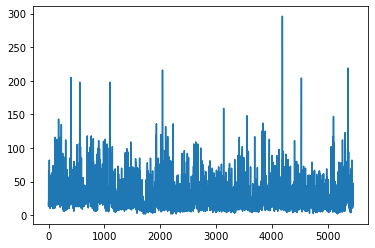

In [110]:
plt.plot(data_csv.index, data_csv['number_of_frames'])

In [ ]:
test_imgs = np.load(base_out + "dev_img_a_0.npy")
test_flow = np.load(base_out + "dev_flow_a_0.npy")
test_corners = np.load(base_out + "dev_corners_0.npy")
test_range = len(test_corners[0]) # the number of frame sequences held in these files

In [44]:
# space dims of the frames in each of the first test_range sequences
areas = np.zeros(test_range)
for j in range(test_range):
    # test_corners[0] is hand index 0
    # j is the index of a frame sequence
    # test_corners[0][j][0] is a pair, the co-ordinates of the rectangle vertex (x_min, y_min) with min values
    # test_corners[0][j][1] is a pair, the co-ordinates of the rectangle vertex (x_max, y_max) with max values
    #   (these co-ordinates are the position of the crop from the original frame)
    #   (so, the two factors below are the width and height of the cropped image)
    areas[j] = (test_corners[0][j][1][0]-test_corners[0][j][0][0])*(test_corners[0][j][1][1]-test_corners[0][j][0][1])

In [ ]:
acc = 0
for j in range(test_range):
    acc += areas[j] * (data_csv['number_of_frames'][indices['dev'][0]+j])
print(acc, test_imgs.shape[0]) # these should be equal, the total number of pixels in the images in the test file

In [ ]:
acc = 0
for j in range(test_range):
    acc += areas[j] * (data_csv['number_of_frames'][indices['dev'][0]+j]-1)
print(acc, test_flow.shape[0]) # these should be equal, the total number of pixels in the flow images in the file

In [46]:
height = test_corners[0][0][1][0]-test_corners[0][0][0][0]
width = test_corners[0][0][1][1]-test_corners[0][0][0][1]
height*width

39494

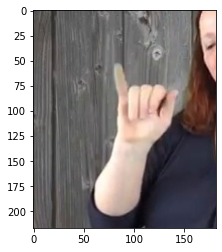

In [59]:
j=40
plt.imshow(test_imgs[0][j*height*width:(j+1)*height*width].reshape(height,width,3))
# to look at other sequences in the file, add offsets to the slices here. for example, the second sequence starts
# at index offset = height * width * number_of_frames, which is the number of pixels in the first sequence

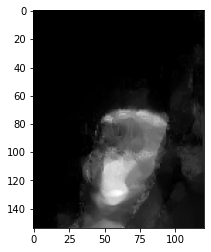

In [307]:
j=30
plt.imshow(flow_to_rgb(test_flow[0][j*height*width:(j+1)*height*width].reshape(height,width,2)))
# sometimes round-off error will produce values slightly outside [0,1] here, giving a clipping warning

In [50]:
# frames with no hand detected
for filename in warnings_list[0]:
    img = cv.imread(filename)
    filepath = Path(filename)
    outname = "temp/" + filepath.parts[-2] + "_" + filepath.parts[-1] + filepath.suffix
    cv.imwrite(outname, img)

<h3>Reconstruction</h3> as a ragged tensor dataset is illustrated below.

In [5]:
import tensorflow as tf
import pandas as pd
from itertools import chain

In [6]:
base_out = "h:/project/cfsw/"
test_rgb = np.load(base_out + "train_img_a_0.npy")
test_flow = np.load(base_out + "train_flow_a_0.npy")
test_corners = np.load(base_out + "train_corners_0.npy")
data_csv = pd.read_csv(base_out+"train_data.csv")

In [7]:
seq_offset = 0
seq_count = test_corners[0].shape[0]
seq_heights = [corners[1][1] - corners[0][1] for corners in test_corners[0]]
seq_widths = [corners[1][0] - corners[0][0] for corners in test_corners[0]]
frame_counts = data_csv['number_of_frames'][seq_offset:seq_offset+seq_count].values
total_frames = frame_counts.sum()
frame_heights = list(chain(*[[seq_heights[j]]*frame_counts[j] for j in range(seq_count)]))
frame_widths = list(chain(*[[seq_widths[j]]*frame_counts[j] for j in range(seq_count)]))
by_widths = list(chain(*[[frame_widths[j]]*frame_heights[j] for j in range(total_frames)]))

In [8]:
reconstruct = tf.RaggedTensor.from_row_lengths(tf.RaggedTensor.from_row_lengths(tf.RaggedTensor.from_row_lengths(test_rgb, 
                                                                                                                 by_widths),
                                                                                  frame_heights),
                                                  frame_counts)
reconstruct.get_shape()

TensorShape([250, None, None, None, 3])

In [9]:
reconstructed_data = tf.data.Dataset.from_tensor_slices(reconstruct)
sample_tensor = reconstructed_data.take(1)
sample_set = [seq for seq in sample_tensor]

(161, None, 3)
(105, 3)


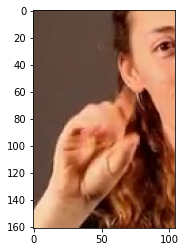

In [10]:
print(sample_set[0][0].get_shape())
print(sample_set[0][0][0].get_shape())
plt.imshow(sample_set[0][0].numpy())

In [11]:
del reconstruct

<h3>Resizing</h3> frames

In [6]:
import pandas as pd
import tensorflow as tf

In [7]:
base_out = "h:/project/cfsw/cfsw_raw/"
base_resize_out = "h:/project/cfsw/cfsw_128/"
splits = ['train', 'dev', 'test']

In [12]:
label_dir = "h:/project/cfsw/cfsw_labels/"
batch_counts = {'train':22, 'dev':4, 'test':4}

for key in splits:
    #data_csv = pd.read_csv(base_out+key+"_data.csv")
    #batch_counts[key] = np.int32(np.ceil(len(data_csv)/batch_size))
    for n in range(batch_counts[key]):
        data_csv = pd.read_csv(label_dir + key + "_data_" + str(n) + ".csv")
        frame_counts = data_csv['number_of_frames'].values
        square_and_rescale_files(base_out+key, n, base_resize_out+key, frame_counts, hand = 0)
        square_and_rescale_files(base_out+key, n, base_resize_out+key, frame_counts, hand = 1)

In [139]:
imgtemp = np.load(base_resize_out+'train_img_a_0_128.npy')
datatemp = pd.read_csv(label_dir+"train_data_0.csv", index_col=0)

In [148]:
datatemp['number_of_frames'][0:5]

0    19
1    13
2    42
3    66
4    32
Name: number_of_frames, dtype: int64

In [142]:
imgtemp.shape[0] == datatemp['number_of_frames'].sum()*128*128

True

In [137]:
seq = imgtemp[0:19*128*128].reshape(19,128,128,3)

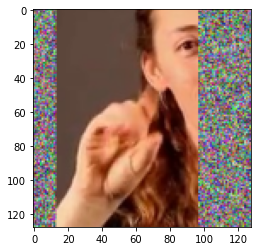

In [138]:
plt.imshow(seq[0])

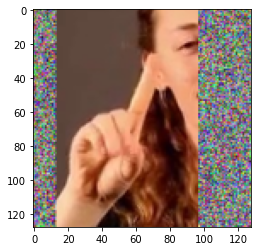

In [143]:
plt.imshow(seq[10])

In [146]:
seq = imgtemp[19*128*128:(19+13)*128*128].reshape(13, 128, 128, 3)

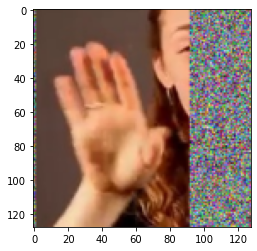

In [147]:
plt.imshow(seq[0])

In [94]:
def pad_serial_flow_sequence_from_corners(flow, corners, frame_counts):
    seq_count = len(frame_counts)
    seq_areas = (corners[:][1][0]-corners[:][0][1])*(corners[:][1][1]-corners[:][0][1])
    in_volumes = target_areas * (frame_counts-1)
    in_offsets = [0] + list(in_volumes.cumsum())
    out_volumes = target_areas * frame_counts
    out_offsets = [0] + list(out_volumes.cumsum())
    new_flow = np.zeros((out_offsets[-1], 2), dtype=np.float16)
    for j in range(seq_count):
        new_flow[out_offsets[j]+seq_areas[j]:out_offsets[j+1]] = flow[in_offsets[j]:in_offsets[j+1]]
    return new_flow

def pad_serial_flow_sequence_square(flow, frame_size, frame_counts):
    seq_count = len(frame_counts)
    seq_area = frame_size*frame_size
    in_volumes = seq_area * (frame_counts-1)
    in_offsets = [0] + list(in_volumes.cumsum())
    out_volumes = seq_area * frame_counts
    out_offsets = [0] + list(out_volumes.cumsum())
    new_flow = np.zeros((out_offsets[-1], 2), dtype=np.float16)
    for j in range(seq_count):
        new_flow[out_offsets[j]+seq_area:out_offsets[j+1]] = flow[in_offsets[j]:in_offsets[j+1]]
    return new_flow

In [142]:
base_dir = "h:/project/cfswp/"
for b in range(41):
    suffix = str(b) + ".npy"
    flow = np.load(base_dir+"cfswp_128/train_flow_a_" + suffix)
    frame_counts = np.load(base_dir+"cfswp_labels/train_frame_counts_" + suffix)
    np.save(base_dir+"temp/train_flow_a_" + suffix, pad_serial_flow_sequence_square(flow, 128, frame_counts))
    flow = np.load(base_dir+"cfswp_128/train_flow_b_" + suffix)
    np.save(base_dir+"temp/train_flow_b_" + suffix, pad_serial_flow_sequence_square(flow, 128, frame_counts))

In [ ]:
# old code, ignore this

batch_size = 500

tv = cv.optflow.DualTVL1OpticalFlow.create(0.23, 0.1, 0.03)
frame_size = 128
resize = False # this being on may cause problems with padded hand frames and finding flow
use_last_on_nondetect = True
keep_on_nondetect = True
# for train split, sequence is skipped if too great a fraction is non-detects
skip_threshold=0.5

total_frames = 0
justnow = time()
warnings_list=[[],[]]

#images = {key: [[],[]] for key in splits}
#geom_img = {key: [[],[]] for key in splits}
#geom_wrl = {key: [[],[]] for key in splits}
#dims = {key: [[],[]] for key in splits}

for key in splits:
    batch_number = 0
    total_size = indices[key][1]-indices[key][0]
    while batch_number*batch_size <= total_size:
        # ready lists for the coming batch
        # two lists, one for hand A and one for hand B
        images = [[],[]]
        corners = [[],[]]
        flow=[[],[]]
        flow_corners=[[],[]]
        geom_img = [[],[]]
        geom_wrl = [[],[]]
        for j in range(indices[key][0]+batch_number*batch_size, indices[key][0]+(batch_number+1)*batch_size):
            if j >= indices[key][1]:
                break
            # for mp.Hands we use static_mode off (it's faster and catches some frames that get missed in static mode)
            #  so, mp.Hands must be told that this is the start of a new frame sequence
            hands_two.reset()
            # maintain lists local to this sequence
            # seq will be skipped if exception occurs, or it's in train split and too many nondetects occur
            last_frame=0
            excepted = False
            images_local=[[],[]]
            corners_local=[[],[]]
            flow_local=[[],[]]
            flow_corners_local=[[],[]]
            geom_img_local=[[],[]]
            geom_wrl_local=[[],[]]
            directory = base_in + data_csv['filename'][j] + "/"
            frame_count = data_csv['number_of_frames'][j]
            print(j, data_csv['filename'][j], frame_count)
            
            for k in range(1, frame_count+1):
                # filenames are 4 characters, the frame number padded with zeros on the left
                if k >= 100:
                    filepath = directory + "0"+str(k)+".jpg"
                elif k >= 10:
                    filepath = directory + "00"+str(k)+".jpg"
                else:
                    filepath = directory + "000"+str(k)+".jpg"
                image = cv.cvtColor(cv.imread(filepath), cv.COLOR_BGR2RGB)
                ret, boxes, crnrs, marks_img, marks_wrl = get_hands_from_image(image, pad_constant=10)
                
                if ret == 0:
                    warnings_list[0].append(filepath)
                    if use_last_on_nondetect and k >= 2:
                        ret = 1
                        crnrs[0] = corners_local[0][-1]
                        boxes[0] = get_rectangle(crnrs[0], image)
                    elif keep_on_nondetect:
                        ret = 1
                        boxes[0] = square_and_rescale(boxes[0], frame_size)
                pad_range=range(ret, 2)
                for hand in range(ret):
                    if hand >= 2:
                        continue
                    try:
                        if resize:
                            boxes[hand] = square_and_rescale(boxes[hand], frame_size)
                        # so images is a flattened list of RGB pixels
                        images_local[hand].append(boxes[hand].reshape(-1,3))
                        if k >= 2:
                            # if there was a nondetection now or last frame we calculate flow on the intersection
                            if corners_local[hand][-1] == [(0,0), last_frame.shape[0:2]] or crnrs[hand] == [(0,0), image.shape[0:2]]:
                                    flow_crnrs = get_rectangle_meet_corners([crnrs[hand], corners_local[hand][-1]])
                            # otherwise, calculate flow on the join of the bounding boxes        
                            else:
                                flow_crnrs = get_rectangle_join_corners([crnrs[hand], corners_local[hand][-1]])                      
                            
                            flow_local[hand].append(tv.calc(cv.cvtColor(get_rectangle(flow_crnrs, last_frame), 
                                                                        cv.COLOR_RGB2GRAY),
                                                            cv.cvtColor(get_rectangle(flow_crnrs, image), 
                                                                        cv.COLOR_RGB2GRAY),
                                                           None).reshape(-1,2))
                            flow_corners_local[hand].append(flow_crnrs)
                        corners_local[hand].append(crnrs[hand])
                        geom_img_local[hand].append(marks_img[hand])
                        geom_wrl_local[hand].append(marks_wrl[hand])

                    except:
                        print("Exc:", filepath, hand, ret)
                        #pad_range=range(hand, 2)
                        excepted=True
                        warnings_list[1].append(filepath)
                for hand in pad_range:
                    pad_size = 1
                    if resize:
                        pad_size = frame_size
                    images_local[hand].append([np.zeros((pad_size*pad_size*3), dtype=np.uint8)])
                    if k >= 2:
                        flow_local[hand].append([np.zeros((pad_size*pad_size*2), dtype=np.float32)])
                        flow_corners_local[hand].append([(0,0), (pad_size, pad_size)])
                    corners_local[hand].append([(0,0), (pad_size, pad_size)])
                    geom_img_local[hand].append(np.zeros((21,3), dtype=np.float32))
                    geom_wrl_local[hand].append(np.zeros((21,3), dtype=np.float32))
                total_frames += 1
                last_frame = image
                                                    
            if excepted or (key == 'train' and nondetect_local >= frame_count*skip_threshold):
                print("Skipping " + data_csv['partition'][j] + "/" + data_csv['filename'][j] + 
                      ", lost frames = " +str(nondetect_local) + "/" + str(frame_count)+
                      ", exc = " + str(excepted))
            else:
                for hand in range(2):
                    images[hand].append(np.concatenate(images_local[hand], axis=0))
                    flow[hand].append(np.concatenate(flow_local[hand], axis=0))
                    corners[hand].append(corners_local[hand])
                    flow_corners[hand].append(flow_corners_local[hand])
                    geom_img[hand].append(geom_img_local[hand])
                    geom_wrl[hand].append(geom_wrl_local[hand])
        # save batch to file
        batch_suffix = "_" + str(batch_number) + ".npy"
        # ragged arrays flattened to array of pixel channels
        np.save(base_out+key+"_img_a"+batch_suffix, np.concatenate(images[0], axis=0))
        np.save(base_out+key+"_img_b"+batch_suffix, np.concatenate(images[1], axis=0))
        np.save(base_out+key+"_flow_a"+batch_suffix, np.concatenate(flow[0], axis=0))
        np.save(base_out+key+"_flow_b"+batch_suffix, np.concatenate(flow[1], axis=0))
        # fixed-size arrays indexed by sequence number
        np.save(base_out+key+"_corners_a"+batch_suffix, corners[0])
        np.save(base_out+key+"_corners_b"+batch_suffix, corners[1])
        np.save(base_out+key+"_flow_corners_a"+batch_suffix, flow_corners[0])
        np.save(base_out+key+"_flow_corners_b"+batch_suffix, flow_corners[1])
        np.save(base_out+key+"_geom_img_a"+batch_suffix, geom_img[0])
        np.save(base_out+key+"_geom_img_b"+batch_suffix, geom_img[1])
        np.save(base_out+key+"_geom_wrl_a"+batch_suffix, geom_wrl[0])
        np.save(base_out+key+"_geom_wrl_b"+batch_suffix, geom_wrl[1])
        batch_number += 1
now = time()
print("Elapsed time", now-justnow, "FPS", total_frames/(now-justnow), "lost fraction", len(warnings_list[0])/total_frames)